## TITLE:  Forecasting Future Sales: A Predictive Analysis of Corporación Favorita Grocery

# Intro

## General

A key factor in a company's retail performance is the ability to properly estimate sales and manage inventories. The key problem is predicting the sales and inventory requirements for each location to avoid overstocking and understocking, allowing the business to offer the greatest customer service while reducing losses and guaranteeing the store's sustainability.

In this research, we the Monaco group plan to utilize sevaral time series forecasting method to forecast store sales for the Ecuadorian grocery retailer Corporation Favorita. Dates, stores, product details, whether the item was on sale, and sales statistics are all included in the training data. Separate files are also provided with further information that could be helpful in developing the models.

# Setup

## Installation
Here is the section to install all the packages/libraries that will be needed to tackle the challlenge.

In [1]:
# !pip install -q <lib_001> <lib_002> ...

!pip install sweetviz
!pip install catboost
!pip install xgboost
!pip install lightgbm

## Importation
Here is the section to import all the packages/libraries that will be used through this notebook.

In [2]:
# Data handling
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

#display all columns and rows 
pd.set_option('display.max_columns', None)

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import matplotlib.pyplot as plt
import seaborn as sns 

# EDA (pandas-profiling, etc. )
#from pandas_profiling import ProfileReport
from datetime import date
import sweetviz as sv

# Feature Processing (Scikit-learn processing, etc. )


# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_log_error


# Other packages
import os

import xgboost as xgb
import catboost as cb

from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings('ignore')



# Data Loading
Here is the section to load the datasets (train, eval, test) and the additional files

In [3]:
#load the data 

Train_df = pd.read_csv('train.csv')
stores_df = pd.read_csv('stores.csv')
Transaction_df = pd.read_csv('transactions.csv')
oil_df = pd.read_csv('oil.csv')
submission_df = pd.read_csv('sample_submission.csv')
test_df = pd.read_csv('test.csv')
Holiday_df = pd.read_csv('holidays_events.csv')

# Exploratory Data Analysis: EDA

Details of the data cleaing process has been provided in the EDA notebook which can be found here: 

https://github.com/aliduabubakari/Forecasting-Future-Sales-for-Corporaci-n-Favorita-Grocery/blob/main/ML_LP2-MONACO-EDA-FINAL.ipynb 

# Feature Processing & Engineering
Here is the section to **clean**, **process** the dataset and **create new features**.

## Drop Duplicates

In [4]:
# Use pandas.DataFrame.drop_duplicates method

Train_df.duplicated().any(), 
stores_df.duplicated().any(), 
oil_df.duplicated().any(),  
test_df.duplicated().any(),  
Holiday_df.duplicated().any() 

False

There are no duplicates in the data 

In [5]:
#checking missing values
null_values=pd.isnull(oil_df).sum()
null_values

date           0
dcoilwtico    43
dtype: int64

oil_df has 43 missing values 

## Impute Missing Values

In [6]:
#Filling missing values in oil data with the the value before that missing data
oil_df = oil_df.bfill()

In [7]:
#checking missing values
null_values=pd.isnull(oil_df).sum()
null_values

date          0
dcoilwtico    0
dtype: int64

## New Features Creation

In [8]:
#create a new column known as day which is the same as the date column
#This is a helpful trick to prevent continuous re-indexing 

Train_df['day'] = Train_df['date']
test_df['day'] = test_df['date']

In [9]:
Train_df.head()

,id,date,store_nbr,family,sales,onpromotion,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01
2,2,2013-01-01,1,BEAUTY,0.0,0,2013-01-01
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013-01-01
4,4,2013-01-01,1,BOOKS,0.0,0,2013-01-01


In [10]:
#Check the last 4 rows of the Transaction dataset

Transaction_df.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [11]:
#Check the last 4 rows of the test dataset
test_df.tail()

,id,date,store_nbr,family,onpromotion,day
28507,3029395,2017-08-31,9,POULTRY,1,2017-08-31
28508,3029396,2017-08-31,9,PREPARED FOODS,0,2017-08-31
28509,3029397,2017-08-31,9,PRODUCE,1,2017-08-31
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017-08-31
28511,3029399,2017-08-31,9,SEAFOOD,0,2017-08-31


In [12]:
#Convert date column to datetime attribute for each dataset with date column 

Train_df["date"] = pd.to_datetime(Train_df["date"], format='%Y-%m-%d')
Transaction_df["date"] = pd.to_datetime(Transaction_df["date"], format='%Y-%m-%d')
oil_df["date"] = pd.to_datetime(oil_df["date"], format='%Y-%m-%d')
Holiday_df["date"] = pd.to_datetime(Holiday_df["date"], format='%Y-%m-%d')

test_df["date"] = pd.to_datetime(test_df["date"], format='%Y-%m-%d')

In [13]:
#Merge all the dataset 
#Use left-join to main data consistency 

merged_df = pd.merge(Train_df, stores_df, on='store_nbr', how='left')
merged_df = pd.merge(merged_df,Transaction_df, on=['store_nbr','date'], how='left')
merged_df = pd.merge(merged_df,oil_df, on=['date'], how='left')
merged_df = pd.merge(merged_df,Holiday_df, on=['date'], how='left')


In [14]:
# merge stores_df to test_df on 'store_nbr'
merged_test_df = pd.merge(test_df, stores_df, on='store_nbr')

The assumption for using the mean transaction to impute missing values is that the missing values are missing at random (MAR) or missing completely at random (MCAR), meaning that there is no systematic reason for the missing values. 

In this case, since the missing values are in the test set and not the training set, it is assumed that the missing values are missing at random and that the mean transaction is a reasonable estimate for the missing values. 

In [15]:
# Calculate the mean for the transaction column
mean_transaction = Transaction_df['transactions'].mean()

# Add the missing feature with all zeros
merged_test_df['transactions'] = mean_transaction

In [16]:
#dcoilwtico

# Calculate the mean for dcoilwtico column
mean_dcoilwtico = oil_df['dcoilwtico'].mean()

# Add the missing feature with all zeros
merged_test_df['dcoilwtico'] = mean_dcoilwtico

In [17]:
merged_test_df.head(2)

,id,date,store_nbr,family,onpromotion,day,city,state,type,cluster,transactions,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325
1,3000889,2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325


In [18]:
merged_df.head(2)

,id,date,store_nbr,family,sales,onpromotion,day,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [19]:
#Drop the ID attribute. It doesnt contribute to any intelligence and may create bias. 

merged_df = merged_df.drop(['id'], axis=1)

merged_test_df = merged_test_df.drop(['id'], axis=1)

### Check and Impute Missing Values

In [20]:
#Check for missing values after the merge 
merged_test_df.isnull().sum()


date            0
store_nbr       0
family          0
onpromotion     0
day             0
city            0
state           0
type            0
cluster         0
transactions    0
dcoilwtico      0
dtype: int64

In [21]:
#Check for missing values after the merge 
merged_df.isnull().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
day                   0
city                  0
state                 0
type_x                0
cluster               0
transactions     249117
dcoilwtico       878526
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

There are several missing values since we utilized a left-join 

In [22]:
#Dealing with missing values 

#Filling the missing data using the Backfill method
merged_df["transactions"].fillna(method='bfill', inplace=True)

merged_df["dcoilwtico"].fillna(method='bfill', inplace=True)

In [23]:
# Find the mode of the 'type_y' column
mode = merged_df['type_y'].mode()[0]

# Replace missing values in the 'type_y' column with the mode
merged_df['type_y'].fillna(mode, inplace=True)

In [24]:
# Find the mode of the 'locale' column
mode = merged_df['locale'].mode()[0]

# Replace missing values in the 'locale' column with the mode
merged_df['locale'].fillna(mode, inplace=True)

In [25]:
# Find the mode of the 'description' column
mode = merged_df['description'].mode()[0]

# Replace missing values in the 'description' column with the mode
merged_df['description'].fillna(mode, inplace=True)

In [26]:
# Find the mode of the 'locale_name' column
mode = merged_df['locale_name'].mode()[0]

# Replace missing values in the 'locale_name' column with the mode
merged_df['locale_name'].fillna(mode, inplace=True)

In [27]:
# Find the mode of the 'transferred' column
mode = merged_df['transferred'].mode()[0]

# Replace missing values in the 'locale_name' column with the mode
merged_df['transferred'].fillna(mode, inplace=True)

In [28]:
merged_df.isnull().sum()

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
day             0
city            0
state           0
type_x          0
cluster         0
transactions    0
dcoilwtico      0
type_y          0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64

All missing values have been dealt with 

In [29]:
merged_df.head()

,date,store_nbr,family,sales,onpromotion,day,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [30]:
#Set date column as index
merged_df = merged_df.set_index('date')
merged_test_df= merged_test_df.set_index('date')

In [31]:
#rename column
merged_df.rename(columns = {'type_x':'Store_type'}, inplace = True)
merged_df.rename(columns = {'type_y':'Holiday_type'}, inplace = True)

#rename column
merged_test_df.rename(columns = {'type':'Store_type'}, inplace = True)

In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     int64  
 1   family        object 
 2   sales         float64
 3   onpromotion   int64  
 4   day           object 
 5   city          object 
 6   state         object 
 7   Store_type    object 
 8   cluster       int64  
 9   transactions  float64
 10  dcoilwtico    float64
 11  Holiday_type  object 
 12  locale        object 
 13  locale_name   object 
 14  description   object 
 15  transferred   bool   
dtypes: bool(1), float64(3), int64(3), object(9)
memory usage: 375.8+ MB


### STATISTICAL DESCRIPTION OF FINAL DATASET

In [33]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,3054348.0,27.500000,15.585787,1.00,14.00,27.50,41.000,54.00
sales,3054348.0,359.020892,1107.285897,0.00,0.00,11.00,196.011,124717.00
onpromotion,3054348.0,2.617480,12.254939,0.00,0.00,0.00,0.000,741.00
cluster,3054348.0,8.481481,4.649735,1.00,4.00,8.50,13.000,17.00
transactions,3054348.0,1664.933975,955.738649,5.00,1032.00,1357.00,2027.250,8359.00
dcoilwtico,3054348.0,67.789300,25.702576,26.19,46.28,53.19,95.800,110.62


In [34]:
merged_test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,28512.0,27.500000,1.558606e+01,1.000000,14.000000,27.500000,41.000000,54.000000
onpromotion,28512.0,6.965383,2.068395e+01,0.000000,0.000000,0.000000,6.000000,646.000000
cluster,28512.0,8.481481,4.649816e+00,1.000000,4.000000,8.500000,13.000000,17.000000
transactions,28512.0,1694.602158,8.608518e-10,1694.602158,1694.602158,1694.602158,1694.602158,1694.602158
dcoilwtico,28512.0,67.673325,4.953991e-11,67.673325,67.673325,67.673325,67.673325,67.673325


## Features Creation

Create new attributes 'Year', 'Month' and 'Weekday Name'

In [35]:
#Create new attributes 'Year', 'Month' and 'Weekday Name'
merged_df['Year'] = merged_df.index.year
merged_df['Month'] = merged_df.index.month_name()
merged_df['Weekday_Name'] = merged_df.index.day_name()

Create new attributes 'Year', 'Month' and 'Weekday Name'

In [36]:
#Create new attributes 'Year', 'Month' and 'Weekday Name'
merged_test_df['Year'] = merged_test_df.index.year
merged_test_df['Month'] = merged_test_df.index.month_name()
merged_test_df['Weekday_Name'] = merged_test_df.index.day_name()

Change data attribute to datetime for consistency 

In [37]:
#Change data attribute to datetime for consistency 
merged_df["day"] = pd.to_datetime(merged_df["day"], format='%Y-%m-%d')

#Change data attribute to datetime for consistency 
merged_test_df["day"] = pd.to_datetime(merged_test_df["day"], format='%Y-%m-%d')


In [38]:
#Check the first 4 records of the merged_dataset
merged_df.head()

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,description,transferred,Year,Month,Weekday_Name
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BEAUTY,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BEVERAGES,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BOOKS,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday


In [39]:
#Check the first 4 records of the merged_test_dataset
merged_test_df.head()

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Year,Month,Weekday_Name
date,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BEAUTY,2,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BEVERAGES,20,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BOOKS,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday


Extracting Date Features from Day Column in Merged DataFrame

In [40]:
merged_df['day'] = pd.to_datetime(merged_df['day'])
merged_df['week'] = merged_df['day'].dt.isocalendar().week
merged_df['quarter'] = merged_df['day'].dt.quarter
merged_df['month'] = merged_df['day'].dt.month
merged_df['weekday'] = merged_df['day'].dt.weekday
merged_df['Day'] = merged_df['day'].dt.day

Extracting Date Features from Day Column in Merged test DataFrame

In [41]:
merged_test_df['day'] = pd.to_datetime(merged_test_df['day'])
merged_test_df['week'] = merged_test_df['day'].dt.isocalendar().week
merged_test_df['quarter'] = merged_test_df['day'].dt.quarter
merged_test_df['month'] = merged_test_df['day'].dt.month
merged_test_df['weekday'] = merged_test_df['day'].dt.weekday
merged_test_df['Day'] = merged_test_df['day'].dt.day

In [42]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,description,transferred,Year,Month,Weekday_Name,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday,1,1,1,1,1
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday,1,1,1,1,1


In [43]:
merged_test_df[:2]

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Year,Month,Weekday_Name,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday,33,3,8,2,16
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday,33,3,8,2,16


Dropping Columns ('Month', 'Weekday_Name', 'description') from Merged DataFrames

In [44]:
merged_df = merged_df.drop(['Month', 'Weekday_Name', 'description'], axis=1)

merged_test_df = merged_test_df.drop(['Month', 'Weekday_Name'], axis=1)

In [45]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1


#### Lag Features

We created Lag Features:
These features involve using previous values of the target variable. By shifting the week column by 1 position and assigning the result to a new column week_lag_1, we effectively create a lagged variable that contains the week of the previous observation. 

In [46]:
#Creating lags
#creating a new column called 'week_lag_1' in the merged_df dataframe, 
#which contains the values of the 'week' column shifted by 1 row. 

merged_df['week_lag_1'] = merged_df['week'].shift(1)

merged_test_df['week_lag_1'] = merged_test_df['week'].shift(1)

The .shift() function in pandas allows us to shift the position of a column by a specified number of rows, either in the positive direction (towards the bottom) or in the negative direction (towards the top).

In [47]:
#Creating sales for next day
merged_df['next_day_sales'] = merged_df['week'].shift(-1)

#Creating sales for next day
merged_test_df['next_day_sales'] = merged_test_df['week'].shift(-1)

#### Moving Average Features

We created Moving Average Features: This is based on the moving average of your target variable. Moving average" and "rolling average" are two different names for the same concept. It refers to a statistical technique that's used to smooth out fluctuations in data over time.

For example, we create features like "week_ma_7", "week_ma_14", week_ma_30 etc. to capture the long-term trends in the target variable.

In [48]:
for i in [7, 14, 30]:
    merged_df["week_ma_{}".format(i)] = merged_df["week"].rolling(i).mean()

In [49]:
for i in [7, 14, 30]:
    merged_test_df["week_ma_{}".format(i)] = merged_test_df["week"].rolling(i).mean()

#### The rolling method Features

The rolling method is being applied to the "week" column of the merged_df DataFrame with different window sizes (7, 14, and 30), which creates a rolling window object. The mean and std methods are applied to these window objects to calculate the rolling mean and standard deviation, respectively, for each window size.

In [50]:
merged_df['rolling_mean_7'] = merged_df['week'].rolling(7).mean().reset_index(level=0, drop=True)
merged_df['rolling_mean_14'] = merged_df['week'].rolling(14).mean().reset_index(level=0, drop=True)
merged_df['rolling_mean_30'] = merged_df['week'].rolling(30).mean().reset_index(level=0, drop=True)

merged_df['rolling_std_7'] = merged_df['week'].rolling(7).std().reset_index(level=0, drop=True)
merged_df['rolling_std_14'] = merged_df['week'].rolling(14).std().reset_index(level=0, drop=True)
merged_df['rolling_std_30'] = merged_df['week'].rolling(30).std().reset_index(level=0, drop=True)


In [51]:
merged_test_df['rolling_mean_7'] = merged_test_df['week'].rolling(7).mean().reset_index(level=0, drop=True)
merged_test_df['rolling_mean_14'] = merged_test_df['week'].rolling(14).mean().reset_index(level=0, drop=True)
merged_test_df['rolling_mean_30'] = merged_test_df['week'].rolling(30).mean().reset_index(level=0, drop=True)

merged_test_df['rolling_std_7'] = merged_test_df['week'].rolling(7).std().reset_index(level=0, drop=True)
merged_test_df['rolling_std_14'] = merged_test_df['week'].rolling(14).std().reset_index(level=0, drop=True)
merged_test_df['rolling_std_30'] = merged_test_df['week'].rolling(30).std().reset_index(level=0, drop=True)


#### The difference Features

The ".diff()" function is being used to calculate the difference between the current value and the previous value of the "week" column, where the number of periods to shift backward is specified as 1. This means that for each row in the dataframe, the value in the "diff_1" column will be the difference between the current week's value and the week's value from the previous row.

In [52]:
merged_df['diff_1'] = merged_df['week'].diff(periods=1)
merged_test_df['diff_1'] = merged_test_df['week'].diff(periods=1)

#### The percentage change Features

calculates the percentage change between each element and the previous element of the 'week' column. The .pct_change() is a Pandas method used to calculate the percentage change between each element in a series or a dataframe column. It calculates the percentage difference between each element and the previous element, and returns a new series or dataframe column containing the calculated values.

In [53]:
merged_df['pct_change'] = merged_df['week'].pct_change()
merged_test_df['pct_change'] = merged_test_df['week'].pct_change()

#### The Min and Max Values Features 

The min() method returns the smallest value in the DataFrame, while the max() method returns the largest value in the DataFrame. The Min column contains the minimum value of the Day column in the respective dataframe, and the Max column contains the maximum value of the Day column in the respective dataframe.

In [54]:
#Min and Max Values
merged_df['Min'] = merged_df['Day'].min()
merged_df['Max'] = merged_df['Day'].max()

#Min and Max Values
merged_test_df['Min'] = merged_test_df['Day'].min()
merged_test_df['Max'] = merged_test_df['Day'].max()

In [55]:
merged_test_df.head(2)

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,33,3,8,2,16,<NA>,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,16,31
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,33,3,8,2,16,33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31


In [56]:
merged_df.head(2)

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1,<NA>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31


## Features Encoding

#### Onpromotion Encoded

We create a binary encoding of the "onpromotion" variable, where 1 indicates that the product was on promotion on a given day and 0 indicates that it was not on promotion.

In [57]:

#create a new column 'onpromotion_encoded'
merged_df['onpromotion_encoded'] = np.where(merged_df['onpromotion'] > 1, 1, 0)

merged_test_df['onpromotion_encoded'] = np.where(merged_test_df['onpromotion'] > 1, 1, 0)

#### Bining the Onpromotion

We utilize Bining on the onpromotion column. Binning is a data preprocessing technique used to transform continuous numerical data into categorical data.

In [58]:
# Determine the minimum and maximum values of the 'onpromotion' column
min_val = merged_df['onpromotion'].min()
max_val = merged_df['onpromotion'].max()

# Add more labels
bins = np.arange(min_val, max_val, (max_val - min_val) / 5)
labels = [f"bin_{i}" for i in range(len(bins) - 1)]

merged_df['Promotions'] = pd.cut(merged_df["onpromotion"], bins=bins, labels=labels)


If we have any missing values after the bining, then replace this with the mode value. This is an assumption which is based on the fact that the onpromotion column consist of the count of products on promotion. 

In [59]:
# Find the mode of the 'Promotions' column
mode = merged_df['Promotions'].mode()[0]

#Lets replace the missing values
merged_df['Promotions'].fillna(mode, inplace=True)

In [60]:
# Determine the minimum and maximum values of the 'onpromotion' column
min_val = merged_test_df['onpromotion'].min()
max_val = merged_test_df['onpromotion'].max()

# Add more labels
bins = np.arange(min_val, max_val, (max_val - min_val) / 5)
labels = [f"bin_{i}" for i in range(len(bins) - 1)]

merged_test_df['Promotions'] = pd.cut(merged_test_df["onpromotion"], bins=bins, labels=labels)


In [61]:
# Find the mode of the 'Promotions' column
mode = merged_test_df['Promotions'].mode()[0]

#Lets replace the missing values
merged_test_df['Promotions'].fillna(mode, inplace=True)

#### Holiday Attribute Encoding  

In [62]:
merged_df['Holiday_type'].unique()

array(['Holiday', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

We implement a basic encoding of the Holiday type column to reduce the number of encoded outputs when we use one-hot encoder.

If the value of 'Holiday_type' is one of the specified strings 'Holiday', 'Additional', 'Event', 'Transfer', or 'Bridge', then the new value of 'Holiday_type' will be 'Holiday'. If it is not one of those strings, then the new value will be 'Workday'.

In [63]:
merged_df['Holiday_type'] = np.where(merged_df['Holiday_type'].isin(['Holiday', 
                                                                     'Additional', 'Event', 'Transfer', 'Bridge']), 
                                                                                                                'Holiday', 'Workday')

In [64]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,Promotions
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1,<NA>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31,0,bin_0
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,False,2013,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,bin_0


#### Family Attribute Encoding  

In [65]:
merged_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

We decided to create broader categories based on data similarities. This will help reduce the dimension of the data and thereby prevent the curse of dimensionality. 

Food: BREAD/BAKERY, DAIRY, DELI, EGGS, FROZEN FOODS, GROCERY I, GROCERY II, MEATS, POULTRY, PREPARED FOODS, PRODUCE, SEAFOOD

Beverages: BEVERAGES, LIQUOR,WINE,BEER

Home and Kitchen: HOME AND KITCHEN I, HOME AND KITCHEN II, HOME APPLIANCES, HOME CARE

Personal Care: BEAUTY, BABY CARE, PERSONAL CARE

Clothing: LADIESWEAR, LINGERIE

Others: AUTOMOTIVE, CELEBRATION, CLEANING, HARDWARE, LAWN AND GARDEN, MAGAZINES, PET SUPPLIES, PLAYERS AND ELECTRONICS, SCHOOL AND OFFICE SUPPLIES



In [66]:
#Implement the new super grouping of product family on the actual family attribute. 

merged_df['family'] = merged_df['family'].replace({
'AUTOMOTIVE': 'Others',
'BABY CARE': 'Personal Care',
'BEAUTY': 'Personal Care',
'BEVERAGES': 'Beverages',
'BOOKS': 'Others',
'BREAD/BAKERY': 'Food',
'CELEBRATION': 'Food',
'CLEANING': 'Others',
'DAIRY': 'Food',
'DELI': 'Food',
'EGGS': 'Food',
'FROZEN FOODS': 'Food',
'GROCERY I': 'Food',
'GROCERY II': 'Food',
'HARDWARE': 'Others',
'HOME AND KITCHEN I': 'Home and Kitchen',
'HOME AND KITCHEN II': 'Home and Kitchen',
'HOME APPLIANCES': 'Home and Kitchen',
'HOME CARE': 'Home and Kitchen',
'LADIESWEAR': 'Clothing',
'LAWN AND GARDEN': 'Others',
'LINGERIE': 'Clothing',
'LIQUOR,WINE,BEER': 'Beverages',
'MAGAZINES': 'Others',
'MEATS': 'Food',
'PERSONAL CARE': 'Personal Care',
'PET SUPPLIES': 'Others',
'PLAYERS AND ELECTRONICS': 'Others',
'POULTRY': 'Food',
'PREPARED FOODS': 'Food',
'PRODUCE': 'Food',
'SCHOOL AND OFFICE SUPPLIES': 'Others',
'SEAFOOD': 'Food'
})

In [67]:
merged_test_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [68]:
merged_test_df['family'] = merged_test_df['family'].replace({
'AUTOMOTIVE': 'Others',
'BABY CARE': 'Personal Care',
'BEAUTY': 'Personal Care',
'BEVERAGES': 'Beverages',
'BOOKS': 'Others',
'BREAD/BAKERY': 'Food',
'CELEBRATION': 'Food',
'CLEANING': 'Others',
'DAIRY': 'Food',
'DELI': 'Food',
'EGGS': 'Food',
'FROZEN FOODS': 'Food',
'GROCERY I': 'Food',
'GROCERY II': 'Food',
'HARDWARE': 'Others',
'HOME AND KITCHEN I': 'Home and Kitchen',
'HOME AND KITCHEN II': 'Home and Kitchen',
'HOME APPLIANCES': 'Home and Kitchen',
'HOME CARE': 'Home and Kitchen',
'LADIESWEAR': 'Clothing',
'LAWN AND GARDEN': 'Others',
'LINGERIE': 'Clothing',
'LIQUOR,WINE,BEER': 'Beverages',
'MAGAZINES': 'Others',
'MEATS': 'Food',
'PERSONAL CARE': 'Personal Care',
'PET SUPPLIES': 'Others',
'PLAYERS AND ELECTRONICS': 'Others',
'POULTRY': 'Food',
'PREPARED FOODS': 'Food',
'PRODUCE': 'Food',
'SCHOOL AND OFFICE SUPPLIES': 'Others',
'SEAFOOD': 'Food'
})

#### OneHotEncoding   

Employ one-hot encoder to encode the categorical attributes 'family', 'Holiday_type', 'Promotions', 'Store_type'

In [69]:
from sklearn.preprocessing import OneHotEncoder

# Fit and transform the 'family', 'Holiday_type', 'Promotions', 'Store_type' columns
features_to_encode = ['family', 'Holiday_type', 'Promotions', 'Store_type', 'city']

# Create an instance of the one-hot encoder
one_hot = OneHotEncoder()

# Fit and transform the data using the one-hot encoder
features_encoded = one_hot.fit_transform(merged_df[features_to_encode])

# Concatenate the encoded columns with the original data
merged_df_encoded = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(features_encoded.toarray(), columns=one_hot.get_feature_names(features_to_encode))], axis=1)

# Drop the original columns
merged_df_encoded = merged_df_encoded.drop(features_to_encode, axis=1)



In [70]:
from sklearn.preprocessing import OneHotEncoder

# Fit and transform the 'family', 'Promotions', 'Store_type' columns
features_to_encode = ['family', 'Promotions', 'Store_type', 'city']

# Create an instance of the one-hot encoder
one_hot = OneHotEncoder()

# Fit and transform the data using the one-hot encoder
features_encoded = one_hot.fit_transform(merged_test_df[features_to_encode])

# Concatenate the encoded columns with the original data
merged_test_df_encoded = pd.concat([merged_test_df.reset_index(drop=True), pd.DataFrame(features_encoded.toarray(), columns=one_hot.get_feature_names(features_to_encode))], axis=1)

# Drop the original columns
merged_test_df_encoded = merged_test_df_encoded.drop(features_to_encode, axis=1)



Set Date as Index in Encoded Dataframes

In [71]:
merged_df_encoded.reset_index(inplace=True)
merged_df_encoded = merged_df_encoded.set_index('day')

merged_test_df_encoded.reset_index(inplace=True)
merged_test_df_encoded = merged_test_df_encoded.set_index('day')

In [72]:
merged_df_encoded.tail()

,index,store_nbr,sales,onpromotion,state,cluster,transactions,dcoilwtico,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-15,3054343,9,438.133,0,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,33,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054344,9,154.553,1,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,33,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054345,9,2419.729,148,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,33,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054346,9,121.000,8,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,33,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054347,9,16.000,0,Pichincha,6,2155.0,47.57,Local,Riobamba,False,2017,33,3,8,1,15,33,<NA>,33.0,33.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Drop some of the original columns

In [73]:
# Drop some of the original columns
merged_df_encoded = merged_df_encoded.drop(['index','onpromotion', 'state', 'locale', 'locale_name', 'Day','transferred', 'Year'], axis=1)

In [74]:
merged_test_df_encoded.tail()

,index,store_nbr,onpromotion,state,cluster,transactions,dcoilwtico,Year,week,quarter,month,weekday,Day,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-31,28507,9,1,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,35,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28508,9,0,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,35,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28509,9,1,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,35,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28510,9,9,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,35,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28511,9,0,Pichincha,6,1694.602158,67.673325,2017,35,3,8,3,31,35,<NA>,35.0,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [75]:
# Drop some of the original columns
merged_test_df_encoded = merged_test_df_encoded.drop(['index','onpromotion','state', 'Day','Year'], axis=1)

In [76]:
merged_df_encoded[:2]

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,<NA>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [77]:
merged_test_df_encoded.head(2)

,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,<NA>,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,16,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Resetting Index of Encoded DataFrames

In [78]:
Final_data = merged_df_encoded.reset_index()
Final_test_data = merged_test_df_encoded.reset_index()

In [79]:
Final_data.head()

,day,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,<NA>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [80]:
Final_data.shape

(3054348, 65)

In [81]:
Final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   day                      28512 non-null  datetime64[ns]
 1   store_nbr                28512 non-null  int64         
 2   cluster                  28512 non-null  int64         
 3   transactions             28512 non-null  float64       
 4   dcoilwtico               28512 non-null  float64       
 5   week                     28512 non-null  UInt32        
 6   quarter                  28512 non-null  int64         
 7   month                    28512 non-null  int64         
 8   weekday                  28512 non-null  int64         
 9   week_lag_1               28511 non-null  UInt32        
 10  next_day_sales           28511 non-null  UInt32        
 11  week_ma_7                28506 non-null  float64       
 12  week_ma_14               28499 n

In [82]:
Final_test_data.shape

(28512, 62)

###### Further checks on the final dataset

In [83]:
# check missing values; 

null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

week_lag_1               1
next_day_sales           1
week_ma_7                6
week_ma_14              13
week_ma_30              29
rolling_mean_7     3054348
rolling_mean_14    3054348
rolling_mean_30    3054348
rolling_std_7      3054348
rolling_std_14     3054348
rolling_std_30     3054348
diff_1                   1
pct_change               1
dtype: int64


In [84]:
#Final_test_data.shape
null_cols = Final_test_data.columns[Final_test_data.isnull().any()]
null_count = Final_test_data[null_cols].isnull().sum()
print(null_count)

week_lag_1             1
next_day_sales         1
week_ma_7              6
week_ma_14            13
week_ma_30            29
rolling_mean_7     28512
rolling_mean_14    28512
rolling_mean_30    28512
rolling_std_7      28512
rolling_std_14     28512
rolling_std_30     28512
diff_1                 1
pct_change             1
dtype: int64


Since we have a number of missing values, lets dealt with it.

for most attributes we use "backward fill" and it fills missing values with the next known non-null value.

In [85]:
# bfill missing values

Final_data.fillna(method='bfill', inplace=True)

Since there were no non-null values after the missing values, so 'bfill' had nothing to fill in. In this case, 'ffill' could still work if there were non-null values before the missing values. so for next_day_sales we use 'ffill'. 

In [86]:

Final_data['next_day_sales'].fillna(method='ffill', inplace=True)

In [87]:
Final_test_data.fillna(method='bfill', inplace=True)

Final_test_data['next_day_sales'].fillna(method='ffill', inplace=True)


In [88]:
#Check data shape 

Final_data.shape

(3054348, 65)

In [89]:
#Check null-values again;

null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

rolling_mean_7     3054348
rolling_mean_14    3054348
rolling_mean_30    3054348
rolling_std_7      3054348
rolling_std_14     3054348
rolling_std_30     3054348
dtype: int64


It is likely that the missing values in the rolling mean columns were due to the fact that the first n rows, where n is the window size of the rolling mean, do not have enough data to calculate a rolling mean. By default, the missing values for those first n rows are filled with NaN values.

therefore we decided to drop this column

In [90]:
#Final_test_data.shape
null_cols_test = Final_test_data.columns[Final_test_data.isnull().any()]
null_count_test = Final_test_data[null_cols_test].isnull().sum()
print(null_count_test)

rolling_mean_7     28512
rolling_mean_14    28512
rolling_mean_30    28512
rolling_std_7      28512
rolling_std_14     28512
rolling_std_30     28512
dtype: int64


In [91]:
#Drop all null values; 

Final_data = Final_data.drop(null_cols, axis=1)

In [92]:
null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

Series([], dtype: float64)


All missing values dealt with 

In [93]:
Final_test_data = Final_test_data.drop(null_cols_test, axis=1)

In [94]:
#Final_test_data.shape
null_cols_test = Final_test_data.columns[Final_test_data.isnull().any()]
null_count_test = Final_test_data[null_cols_test].isnull().sum()
print(null_count_test)

Series([], dtype: float64)


In [95]:
Final_test_data.head(2)

,day,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,33,33.0,33.0,33.0,0,0.0,16,31,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,33,33.0,33.0,33.0,0,0.0,16,31,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [96]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 59 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   day                      datetime64[ns]
 1   store_nbr                int64         
 2   sales                    float64       
 3   cluster                  int64         
 4   transactions             float64       
 5   dcoilwtico               float64       
 6   week                     UInt32        
 7   quarter                  int64         
 8   month                    int64         
 9   weekday                  int64         
 10  week_lag_1               UInt32        
 11  next_day_sales           UInt32        
 12  week_ma_7                float64       
 13  week_ma_14               float64       
 14  week_ma_30               float64       
 15  diff_1                   UInt32        
 16  pct_change               Float64       
 17  Min                      in

## Dataset Scaling 

In [97]:
#change the index label of the DataFrame from 'day' to 'date'

Final_data = Final_data.set_index('day')
Final_data.index.rename('date', inplace=True)

In [98]:
Final_test_data = Final_test_data.set_index('day')
Final_test_data.index.rename('date', inplace=True)

In [99]:
#Resample the data to day with mean attributes 

Final_data_sampled = Final_data.resample('D').mean()

In [100]:
Final_test_data_sampled = Final_test_data.resample('D').mean()

In [101]:
#Copy the final data to a new variable i.e. scaled data

scaled_data = Final_data_sampled.copy()
scaled_data.reset_index(inplace=True)

In [102]:
scaled_test_data = Final_test_data_sampled.copy()
scaled_test_data.reset_index(inplace=True)

#### Standard Scaling 

Scaling of Features is an essential step in modeling the algorithms with the datasets. The data that is usually used for the purpose of modeling is derived through various means such as:

- Questionnaire
- Surveys
- Research
- Scraping, etc.

So, the data obtained contains features of various dimensions and scales altogether. Different scales of the data features affect the modeling of a dataset adversely.

It leads to a biased outcome of predictions in terms of misclassification error and accuracy rates. Thus, it is necessary to Scale the data prior to modeling.

This is when standardization comes into picture.

Standardization is a scaling technique wherein it makes the data scale-free by converting the statistical distribution of the data into the below format:

mean - 0 (zero)
standard deviation - 1

In [103]:
from sklearn.preprocessing import StandardScaler

# Fill any missing values with 0
scaled_data.fillna(0, inplace=True)

It is generally unnecessary to scale or normalize categorical data, as scaling doesn't change the meaning of the categories. However, it is not necessarily wrong to do so, as it is unlikely to cause any major issues. Some machine learning algorithms may even require the input features to be scaled, so in those cases, it would be necessary to scale both numerical and categorical features. In summary, scaling categorical data is not typically necessary, but it also should not cause any major problems.

In [104]:
cols_to_scale = ['store_nbr', 'cluster', 'transactions', 'dcoilwtico', 'week', 'quarter', 'month', 'weekday','week_lag_1', 'next_day_sales', 'week_ma_7', 'week_ma_14', 'week_ma_30', 'diff_1', 'pct_change', 'Min', 'Max']

cols_to_scale_ = ['store_nbr', 'cluster', 'transactions', 'week', 'quarter', 'month', 'weekday', 'week_lag_1', 'next_day_sales', 'week_ma_7', 'week_ma_14', 'week_ma_30', 'diff_1', 'pct_change', 'Min', 'Max']

data_to_scale = scaled_data[cols_to_scale]

Test_data_to_scale = scaled_test_data[cols_to_scale_]


In [105]:
scaler = StandardScaler()

scaled_values = scaler.fit_transform(data_to_scale)

scaled_data_to_merge = pd.DataFrame(scaled_values, columns=cols_to_scale)

In [106]:
scaled_values_ = scaler.fit_transform(Test_data_to_scale)

scaled_test_data_to_merge = pd.DataFrame(scaled_values_, columns=cols_to_scale_)

In [107]:
unscaled_cols = ['date',  'sales', 'onpromotion_encoded', 'family_Beverages', 'family_Clothing', 'family_Food', 'family_Home and Kitchen', 'family_Others', 'family_Personal Care', 'Holiday_type_Holiday', 'Holiday_type_Workday', 'Promotions_bin_0', 'Promotions_bin_1', 'Promotions_bin_2', 'Promotions_bin_3', 'Store_type_A', 'Store_type_B', 'Store_type_C', 'Store_type_D', 'Store_type_E', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad', 'city_Loja','city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba','city_Salinas', 'city_Santo Domingo']

scaled_data_final = pd.concat([scaled_data_to_merge, scaled_data[unscaled_cols]], axis=1)


In [108]:
unscaled_cols = ['date', 'onpromotion_encoded', 'family_Beverages', 'family_Clothing', 'family_Food', 'family_Home and Kitchen', 'family_Others', 'family_Personal Care', 'Promotions_bin_0', 'Promotions_bin_1', 'Promotions_bin_2', 'Promotions_bin_3', 'Store_type_A', 'Store_type_B', 'Store_type_C', 'Store_type_D', 'Store_type_E', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad', 'city_Loja','city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba','city_Salinas', 'city_Santo Domingo']

scaled_test_data_final = pd.concat([scaled_test_data_to_merge, scaled_test_data[unscaled_cols]], axis=1)


Filling missing values with 0 assumes that missing values are equivalent to zero or that they represent a lack of occurrence. It's a common method of imputation used when it's reasonable to assume that missing values have no influence on the analysis or model being built. 

In [109]:
#sets the 'date' column as the index of the 'scaled_data' dataframe
scaled_data_final.set_index('date', inplace=True)

#sets the 'date' column as the index of the 'scaled_test_data' dataframe
scaled_test_data_final.set_index('date', inplace=True)


In [110]:
#Create a dataframe for the scaled data and scaled test data
scaled_data_df = pd.DataFrame(scaled_data_final, columns=scaled_data.columns)

scaled_test_data_df = pd.DataFrame(scaled_test_data_final, columns=scaled_test_data.columns)


The abs() function is used to compute the absolute value of each element in a DataFrame. In this case, it's being used to convert any negative values to their positive counterparts. This is often useful in data preprocessing when dealing with values that are naturally positive but may have been transformed to negative due to some data processing step or error. By taking the absolute value, we ensure that all values are positive, which can simplify further calculations or analysis.

In [111]:
scaled_data_df = abs(scaled_data_df)

scaled_test_data_df = abs(scaled_test_data_df)

In [112]:
scaled_data_df.head(2)

,date,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,0.048737,1.409438,0.048737,0.023527,0.98276,1.630904,1.271288,1.529596,0.993140,1.630915,1.630918,1.630939,1.63098,1.631074,0.048737,0.129139,0.048737,0.048737,0.0,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2013-01-02,NaN,0.048737,278.390807,0.048737,1.278346,0.98276,1.630904,1.271288,1.529596,0.494057,1.630915,1.630918,1.630939,1.63098,1.631074,0.048737,0.129139,0.048737,0.048737,0.0,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [113]:
scaled_test_data_df.head(2)

,date,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,NaN,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.496972,1.186308,1.266854,1.044395,0.778556,0.108315,3.872983,3.208651,0.0,0.0,0.489899,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,0.962402,0.037598,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-17,NaN,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.033131,1.266684,1.266854,1.289999,1.325475,1.371327,0.258199,0.012928,0.0,0.0,0.308642,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [114]:
scaled_data_df = scaled_data_df.drop(['date'], axis=1)

scaled_test_data_df = scaled_test_data_df.drop(['date'], axis=1)

In [115]:
scaled_test_data_df.head(2)

,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.496972,1.186308,1.266854,1.044395,0.778556,0.108315,3.872983,3.208651,0.0,0.0,0.489899,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,0.962402,0.037598,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-17,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.033131,1.266684,1.266854,1.289999,1.325475,1.371327,0.258199,0.012928,0.0,0.0,0.308642,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [116]:
scaled_data_df.head(2)

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home and Kitchen,family_Others,family_Personal Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.048737,1.409438,0.048737,0.023527,0.98276,1.630904,1.271288,1.529596,0.993140,1.630915,1.630918,1.630939,1.63098,1.631074,0.048737,0.129139,0.048737,0.048737,0.0,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2013-01-02,0.048737,278.390807,0.048737,1.278346,0.98276,1.630904,1.271288,1.529596,0.494057,1.630915,1.630918,1.630939,1.63098,1.631074,0.048737,0.129139,0.048737,0.048737,0.0,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


We needed to replace spaces, slashes, and commas in the column names with underscores. This is done to make the column names more computer-readable and to avoid any issues with spaces or special characters in the column names. Espercially when running LightGBM which has issues with spaces or special characters in column names, so it's necessary to replace them with underscores or remove them before training the model. 

In [117]:
# Replace spaces in feature names with underscores
scaled_data_df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
scaled_data_df.rename(columns=lambda x: x.replace("/", "_"), inplace=True)
scaled_data_df.rename(columns=lambda x: x.replace(",", "_"), inplace=True)

# Replace spaces in feature names with underscores
scaled_test_data_df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
scaled_test_data_df.rename(columns=lambda x: x.replace("/", "_"), inplace=True)
scaled_test_data_df.rename(columns=lambda x: x.replace(",", "_"), inplace=True)

## Data Splitting

The next step is to divide the scaled_data_df dataframe into training and validation datasets, and assigning the entire scaled_test_data_df as the final test dataset. We select the first 95% of the rows for the training data using the iloc method with slicing notation, and selects the remaining rows for the validation data.

In [118]:
# Calculate the number of rows in the data
n_rows = scaled_data_df.shape[0]

# Calculate the split point
split_point = int(n_rows * 0.95)

# Select the first 95% of the rows as the training data
train_data = scaled_data_df.iloc[:split_point]

# Select the remaining rows as the validation data
validation_data = scaled_data_df.iloc[split_point:]

# Select the test data

Final_test_data_ = scaled_test_data_df

In [119]:
#Check the two (2) records of the test data 
#Final_test_data_.head(2)

In [120]:
#Check the last four (4) records of the train data 
train_data.tail()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home_and_Kitchen,family_Others,family_Personal_Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El_Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18,0.048737,352.686863,0.048737,0.937060,0.708573,0.349545,0.366212,0.351427,0.005026,0.349547,0.349549,0.349551,0.349558,0.349574,0.048737,0.129139,0.048737,0.048737,0.388328,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-19,0.048737,434.217417,0.048737,0.255391,0.671486,0.349545,0.366212,0.351427,0.504110,0.349547,0.349549,0.349551,0.349558,0.349574,0.048737,0.129139,0.048737,0.048737,0.440516,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-20,0.048737,581.182594,0.048737,0.949582,0.652556,0.349545,0.366212,0.351427,1.003193,0.349547,0.349549,0.349551,0.349558,0.349574,0.048737,0.129139,0.048737,0.048737,0.394501,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-21,0.048737,674.488713,0.048737,0.943097,0.652556,0.349545,0.366212,0.351427,1.502276,0.349547,0.349511,0.349551,0.349558,0.349574,0.048737,0.129139,0.048737,0.048737,0.396184,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-22,0.048737,437.112882,0.048737,0.430164,0.652556,0.282105,0.366212,0.351427,1.492223,0.282144,0.282108,0.282223,0.282361,0.282675,0.048737,0.469710,0.048737,0.048737,0.375982,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [121]:
#Check the first four (4) records of the validation data 
validation_data.head()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home_and_Kitchen,family_Others,family_Personal_Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El_Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-23,0.048737,405.809073,0.048737,0.589624,0.640580,0.282105,0.366212,0.351427,0.993140,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.367565,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,0.998316,0.001684,0.000000,0.000000,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-24,0.048737,418.801138,0.048737,0.599702,0.645602,0.282105,0.366212,0.351427,0.494057,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.401796,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,0.980920,0.017396,0.001122,0.000561,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-25,0.048737,347.984424,0.048737,0.863620,0.739093,0.282105,0.366212,0.351427,0.005026,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.373176,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-26,0.048737,552.475394,0.048737,0.539096,0.700074,0.282105,0.366212,0.351427,0.504110,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.455107,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-27,0.048737,523.131253,0.048737,0.543315,0.698142,0.282105,0.366212,0.351427,1.003193,0.282107,0.282108,0.282109,0.282115,0.282126,0.048737,0.129139,0.048737,0.048737,0.395623,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [122]:
#Check the last four (4) records of the validation data 
validation_data.tail()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,week_ma_7,week_ma_14,week_ma_30,diff_1,pct_change,Min,Max,onpromotion_encoded,family_Beverages,family_Clothing,family_Food,family_Home_and_Kitchen,family_Others,family_Personal_Care,Holiday_type_Holiday,Holiday_type_Workday,Promotions_bin_0,Promotions_bin_1,Promotions_bin_2,Promotions_bin_3,Store_type_A,Store_type_B,Store_type_C,Store_type_D,Store_type_E,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El_Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-11,0.048737,463.733851,0.048737,0.000302,0.729821,0.459734,0.538863,0.5322,0.504110,0.459738,0.459737,0.459747,0.459762,0.459795,0.048737,0.129139,0.048737,0.048737,0.424242,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-12,0.048737,444.798280,0.048737,0.029074,0.776953,0.459734,0.538863,0.5322,1.003193,0.459738,0.459737,0.459747,0.459762,0.459795,0.048737,0.129139,0.048737,0.048737,0.369248,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-13,0.048737,485.768618,0.048737,0.278282,0.776953,0.459734,0.538863,0.5322,1.502276,0.459738,0.459775,0.459747,0.459762,0.459795,0.048737,0.129139,0.048737,0.048737,0.356341,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-14,0.048737,427.004717,0.048737,0.320862,0.776953,0.527174,0.538863,0.5322,1.492223,0.527141,0.527178,0.527075,0.526959,0.526694,0.048737,0.245142,0.048737,0.048737,0.349607,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,1.000000,0.000000,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-15,0.048737,427.980884,0.048737,0.233906,0.777725,0.527174,0.538863,0.5322,0.993140,0.527179,0.527178,0.527188,0.527205,0.527243,0.048737,0.129139,0.048737,0.048737,0.345679,0.060606,0.060606,0.393939,0.121212,0.272727,0.090909,1.0,0.0,0.998316,0.001684,0.0,0.0,0.166667,0.148148,0.277778,0.333333,0.074074,0.037037,0.018519,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.148148,0.018519,0.037037,0.018519,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


To prepare the training data for building a machine learning model by separating the target variable ("sales") from the feature variables ("date" and other columns) and storing them in separate variables. 

The reset_index() method is used to reset the index of the DataFrame after the rows were shuffled during the train-test split, so that the index is continuous and can be used to match the predicted values with the original DataFrame.

In [123]:
train_data2 = train_data.reset_index()

#X_train is a subset of the input features (X) used to train a machine learning model. 
X_train =train_data2.drop(columns=["sales","date"])

# y_train: This is the corresponding output/target variable (y) for the X_train subset. 
y_train=train_data2["sales"]

In [124]:
validation_data = validation_data.reset_index()

#X_validation_test: This is another subset of the input features (X) 
#that is used to validate or test the performance of the model after it has been trained on the X_train set. 
#The validation/test set is used to evaluate the generalization performance of the model and to tune the hyperparameters of the model.

X_validation_test =validation_data.drop(columns=["sales","date"])

#

#y_validation_test: This is the corresponding output/target variable (y) for the X_validation_test subset. 
#The y_validation_test is used to compare the predicted output of the model with the actual output to evaluate the performance of the model.
y_validation_test=validation_data["sales"]


# Using traditional Machine learning methods 

###### Linear regression model

In [125]:
# Import the linear regression model

# Initialize the linear regression model
reg = LinearRegression()

# Fit the linear regression model to the training data
reg.fit(X_train, y_train)

# Predict on the validation test data
y_pred_lg = reg.predict(X_validation_test)

# Calculate the RMSLE
rmsle_lg = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lg))
#print("RMSLE: ", rmsle)

print('Mean Absolute Error for LinearRegression:', mean_absolute_error(y_validation_test, y_pred_lg))
print('Mean Squared Log Error for LinearRegression:', mean_squared_log_error(y_validation_test, y_pred_lg))
print('Mean Squared Error for LinearRegression:', mean_squared_error(y_validation_test, y_pred_lg))
print('Root Mean Squared Error for LinearRegression:', np.sqrt(mean_squared_error(y_validation_test, y_pred_lg)))
print('Root Mean Squared Log Error for LinearRegression:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lg)))


Mean Absolute Error for LinearRegression: 53.944372236323346
Mean Squared Log Error for LinearRegression: 0.018068175661446632
Mean Squared Error for LinearRegression: 4666.129101359171
Root Mean Squared Error for LinearRegression: 68.30907041791134
Root Mean Squared Log Error for LinearRegression: 0.13441791421327232


###### RandomForest Classifier

In [126]:
#RandomForestClassifier()
#from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor

rfm =RandomForestRegressor(n_estimators=100,max_depth=6,n_jobs=3, random_state=0)
rfm.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_jobs=3, random_state=0)

In [127]:
# RandomForestRegressor Prediction
y_pred_Rf= rfm.predict(X_validation_test)

# Calculate the RMSLE
rmsle_RF = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_Rf))

print('Mean Absolute Error for RandomForestRegressor:', mean_absolute_error(y_validation_test, y_pred_Rf))
print('Mean Squared Log Error for RandomForestRegressor:', mean_squared_log_error(y_validation_test, y_pred_Rf))
print('Mean Squared Error for RandomForestRegressor:', mean_squared_error(y_validation_test, y_pred_Rf))
print('Root Mean Squared Error for RandomForestRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_Rf)))
print('Root Mean Squared Log Error for RandomForestRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_Rf)))


Mean Absolute Error for RandomForestRegressor: 31.155355480908046
Mean Squared Log Error for RandomForestRegressor: 0.0071093336034389444
Mean Squared Error for RandomForestRegressor: 1998.6222830368133
Root Mean Squared Error for RandomForestRegressor: 44.705953552483514
Root Mean Squared Log Error for RandomForestRegressor: 0.08431686428846215


##### xgboost Prediction Model

In [128]:
# xgboost Prediction

# Initialize the XGBRegressor
xgb_reg = xgb.XGBRegressor(random_state=0)

# Fit the XGBRegressor to the training data
xgb_reg.fit(X_train, y_train)

# Predict on the validation test data
y_pred_xgb = xgb_reg.predict(X_validation_test)


# Calculate the RMSLE
#rmsle_xgb = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_xgb))
rmsle_xgb = np.sqrt(np.mean((np.log(y_pred_xgb + 1) - np.log(y_validation_test + 1))**2))

print('Root Mean Squared Log Error for xgboost:', rmsle_xgb)

Root Mean Squared Log Error for xgboost: 0.07721015828558117


In [129]:
print('Mean Absolute Error for xgboost:', mean_absolute_error(y_validation_test, y_pred_xgb))
print('Mean Squared Error for xgboost:', mean_squared_error(y_validation_test, y_pred_xgb))
print('Root Mean Squared Error for xgboost:', np.sqrt(mean_squared_error(y_validation_test, y_pred_xgb)))
print('Root Mean Squared Log Error for xgboost:', np.sqrt(np.mean((np.log(y_pred_xgb + 1) - np.log(y_validation_test + 1))**2)))


Mean Absolute Error for xgboost: 26.627759654254127
Mean Squared Error for xgboost: 1401.6054924274756
Root Mean Squared Error for xgboost: 37.43802201542538
Root Mean Squared Log Error for xgboost: 0.07721015828558117


##### lightgbm Model and Prediction

In [130]:
#lightgbm Model and Prediction

import lightgbm as lgb

# Initialize the LightGBM regressor
reg = lgb.LGBMRegressor(random_state=0)

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict on the validation test data
y_pred_lgb = reg.predict(X_validation_test)

rmsle_lgb = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lgb))

In [131]:
print('Mean Absolute Error for LGBMRegressor:', mean_absolute_error(y_validation_test, y_pred_lgb))
print('Mean Squared Log Error for LGBMRegressor:', mean_squared_log_error(y_validation_test, y_pred_lgb))
print('Mean Squared Error for LGBMRegressor:', mean_squared_error(y_validation_test, y_pred_lgb))
print('Root Mean Squared Error for LGBMRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_lgb)))
print('Root Mean Squared Log Error for LGBMRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lgb)))


Mean Absolute Error for LGBMRegressor: 31.914300298000693
Mean Squared Log Error for LGBMRegressor: 0.007537727395801479
Mean Squared Error for LGBMRegressor: 1757.6674329115615
Root Mean Squared Error for LGBMRegressor: 41.924544516447185
Root Mean Squared Log Error for LGBMRegressor: 0.08682008636140302


##### CatBoostRegressor 

In [132]:
# Initialize the CatBoostRegressor
model = cb.CatBoostRegressor(random_state=0)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the validation test data
y_pred_cb = model.predict(X_validation_test)


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 156ms	remaining: 2m 35s
1:	learn: 124.4515551	total: 161ms	remaining: 1m 20s
2:	learn: 121.1051420	total: 166ms	remaining: 55.1s
3:	learn: 118.0131759	total: 171ms	remaining: 42.5s
4:	learn: 115.1225090	total: 176ms	remaining: 34.9s
5:	learn: 112.5008885	total: 180ms	remaining: 29.8s
6:	learn: 109.7836982	total: 185ms	remaining: 26.2s
7:	learn: 107.4033951	total: 190ms	remaining: 23.5s
8:	learn: 104.9744962	total: 195ms	remaining: 21.4s
9:	learn: 102.8218347	total: 199ms	remaining: 19.7s
10:	learn: 100.6806423	total: 204ms	remaining: 18.4s
11:	learn: 98.4500980	total: 210ms	remaining: 17.3s
12:	learn: 96.6125667	total: 214ms	remaining: 16.3s
13:	learn: 94.6094222	total: 220ms	remaining: 15.5s
14:	learn: 92.6806954	total: 226ms	remaining: 14.8s
15:	learn: 90.6257312	total: 230ms	remaining: 14.2s
16:	learn: 88.9471067	total: 235ms	remaining: 13.6s
17:	learn: 87.3550268	total: 240ms	remaining: 13.1s
18:	learn: 85.8057306	total: 24

176:	learn: 43.1792339	total: 1.16s	remaining: 5.4s
177:	learn: 43.1252874	total: 1.17s	remaining: 5.39s
178:	learn: 42.9754305	total: 1.17s	remaining: 5.38s
179:	learn: 42.8965888	total: 1.18s	remaining: 5.37s
180:	learn: 42.7940289	total: 1.18s	remaining: 5.35s
181:	learn: 42.6848537	total: 1.19s	remaining: 5.34s
182:	learn: 42.6480654	total: 1.19s	remaining: 5.33s
183:	learn: 42.5390390	total: 1.2s	remaining: 5.32s
184:	learn: 42.4275283	total: 1.2s	remaining: 5.3s
185:	learn: 42.3883682	total: 1.21s	remaining: 5.29s
186:	learn: 42.2586781	total: 1.21s	remaining: 5.28s
187:	learn: 42.1700440	total: 1.22s	remaining: 5.27s
188:	learn: 42.0591891	total: 1.23s	remaining: 5.26s
189:	learn: 41.9643638	total: 1.23s	remaining: 5.24s
190:	learn: 41.8662348	total: 1.24s	remaining: 5.23s
191:	learn: 41.7522527	total: 1.24s	remaining: 5.23s
192:	learn: 41.6392727	total: 1.25s	remaining: 5.22s
193:	learn: 41.5584768	total: 1.25s	remaining: 5.21s
194:	learn: 41.4472210	total: 1.26s	remaining: 5.2

348:	learn: 32.9534068	total: 2.17s	remaining: 4.04s
349:	learn: 32.9351522	total: 2.18s	remaining: 4.04s
350:	learn: 32.9150012	total: 2.18s	remaining: 4.04s
351:	learn: 32.8423920	total: 2.19s	remaining: 4.03s
352:	learn: 32.8084340	total: 2.2s	remaining: 4.03s
353:	learn: 32.7995784	total: 2.2s	remaining: 4.02s
354:	learn: 32.7532110	total: 2.21s	remaining: 4.01s
355:	learn: 32.7431780	total: 2.21s	remaining: 4.01s
356:	learn: 32.7382603	total: 2.22s	remaining: 4s
357:	learn: 32.7154633	total: 2.23s	remaining: 4s
358:	learn: 32.6697600	total: 2.23s	remaining: 3.99s
359:	learn: 32.6306954	total: 2.24s	remaining: 3.98s
360:	learn: 32.5829184	total: 2.25s	remaining: 3.98s
361:	learn: 32.5562389	total: 2.25s	remaining: 3.97s
362:	learn: 32.5200941	total: 2.26s	remaining: 3.97s
363:	learn: 32.4887051	total: 2.27s	remaining: 3.96s
364:	learn: 32.4553891	total: 2.27s	remaining: 3.96s
365:	learn: 32.4248465	total: 2.28s	remaining: 3.95s
366:	learn: 32.3979115	total: 2.29s	remaining: 3.94s
3

521:	learn: 27.8731281	total: 3.38s	remaining: 3.1s
522:	learn: 27.8564986	total: 3.39s	remaining: 3.09s
523:	learn: 27.8256025	total: 3.39s	remaining: 3.08s
524:	learn: 27.7987174	total: 3.4s	remaining: 3.08s
525:	learn: 27.7790199	total: 3.41s	remaining: 3.07s
526:	learn: 27.7457527	total: 3.41s	remaining: 3.06s
527:	learn: 27.7119580	total: 3.42s	remaining: 3.06s
528:	learn: 27.6961338	total: 3.43s	remaining: 3.05s
529:	learn: 27.6815877	total: 3.44s	remaining: 3.05s
530:	learn: 27.6528157	total: 3.44s	remaining: 3.04s
531:	learn: 27.6335125	total: 3.45s	remaining: 3.04s
532:	learn: 27.6114054	total: 3.46s	remaining: 3.03s
533:	learn: 27.5958754	total: 3.47s	remaining: 3.03s
534:	learn: 27.5717995	total: 3.48s	remaining: 3.02s
535:	learn: 27.5523221	total: 3.48s	remaining: 3.02s
536:	learn: 27.5266876	total: 3.49s	remaining: 3.01s
537:	learn: 27.5067587	total: 3.5s	remaining: 3s
538:	learn: 27.4731735	total: 3.51s	remaining: 3s
539:	learn: 27.4456415	total: 3.51s	remaining: 2.99s
54

687:	learn: 24.3774681	total: 4.59s	remaining: 2.08s
688:	learn: 24.3515830	total: 4.6s	remaining: 2.08s
689:	learn: 24.3375572	total: 4.61s	remaining: 2.07s
690:	learn: 24.3159926	total: 4.61s	remaining: 2.06s
691:	learn: 24.3019148	total: 4.62s	remaining: 2.06s
692:	learn: 24.2714836	total: 4.63s	remaining: 2.05s
693:	learn: 24.2581331	total: 4.63s	remaining: 2.04s
694:	learn: 24.2446404	total: 4.64s	remaining: 2.04s
695:	learn: 24.2217265	total: 4.65s	remaining: 2.03s
696:	learn: 24.2067946	total: 4.66s	remaining: 2.02s
697:	learn: 24.1957388	total: 4.66s	remaining: 2.02s
698:	learn: 24.1668303	total: 4.67s	remaining: 2.01s
699:	learn: 24.1459087	total: 4.68s	remaining: 2s
700:	learn: 24.1331031	total: 4.68s	remaining: 2s
701:	learn: 24.1221171	total: 4.69s	remaining: 1.99s
702:	learn: 24.1100238	total: 4.7s	remaining: 1.99s
703:	learn: 24.1003701	total: 4.71s	remaining: 1.98s
704:	learn: 24.0889058	total: 4.71s	remaining: 1.97s
705:	learn: 24.0446421	total: 4.72s	remaining: 1.97s
7

865:	learn: 21.6039311	total: 5.82s	remaining: 900ms
866:	learn: 21.5981772	total: 5.83s	remaining: 894ms
867:	learn: 21.5681147	total: 5.83s	remaining: 887ms
868:	learn: 21.5519472	total: 5.84s	remaining: 880ms
869:	learn: 21.5439459	total: 5.84s	remaining: 873ms
870:	learn: 21.5242713	total: 5.85s	remaining: 867ms
871:	learn: 21.5120157	total: 5.86s	remaining: 860ms
872:	learn: 21.5062296	total: 5.86s	remaining: 853ms
873:	learn: 21.4866202	total: 5.87s	remaining: 846ms
874:	learn: 21.4740865	total: 5.88s	remaining: 840ms
875:	learn: 21.4721253	total: 5.88s	remaining: 833ms
876:	learn: 21.4558475	total: 5.89s	remaining: 826ms
877:	learn: 21.4465406	total: 5.9s	remaining: 820ms
878:	learn: 21.4380108	total: 5.9s	remaining: 813ms
879:	learn: 21.4282362	total: 5.91s	remaining: 806ms
880:	learn: 21.4199077	total: 5.92s	remaining: 799ms
881:	learn: 21.3945163	total: 5.92s	remaining: 793ms
882:	learn: 21.3784599	total: 5.93s	remaining: 786ms
883:	learn: 21.3700054	total: 5.94s	remaining: 7

In [133]:
print('Mean Absolute Error for CatBoostRegressor:', mean_absolute_error(y_validation_test, y_pred_cb))
#print('Mean Squared Log Error for CatBoostRegressor:', mean_squared_log_error(y_validation_test, y_pred_cb))
print('Mean Squared Error for CatBoostRegressor:', mean_squared_error(y_validation_test, y_pred_cb))
print('Root Mean Squared Error for CatBoostRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_cb)))
#print('Root Mean Squared Log Error for CatBoostRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_cb)))
# Calculate the RMSLE
rmsle_cb =np.sqrt(np.mean((np.log(y_pred_cb + 1) - np.log(y_validation_test + 1))**2))

print("Root Mean Squared Log Error for CatBoostRegressor: ", rmsle_cb)

Mean Absolute Error for CatBoostRegressor: 27.70837614684175
Mean Squared Error for CatBoostRegressor: 1419.7495826387728
Root Mean Squared Error for CatBoostRegressor: 37.679564522944965
Root Mean Squared Log Error for CatBoostRegressor:  0.07653758759288866


##### DecisionTreeRegressor Model and Prediction

In [134]:
#DecisionTreeRegressor Model and Prediction

dtm = DecisionTreeRegressor(random_state=150)
dtm.fit(X_train, y_train)
y_pred_dtm = dtm.predict(X_validation_test)

# Calculate the RMSLE
rmsle_dtm = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_dtm))

#print("RMSLE: ", rmsle)

print('Mean Absolute Error for DecisionTreeRegressor:', mean_absolute_error(y_validation_test, y_pred_dtm))
print('Mean Squared Log Error for DecisionTreeRegressor:', mean_squared_log_error(y_validation_test, y_pred_dtm))
print('Mean Squared Error for DecisionTreeRegressor:', mean_squared_error(y_validation_test, y_pred_dtm))
print('Root Mean Squared Error for DecisionTreeRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_dtm)))
print('Root Mean Squared Log Error for DecisionTreeRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_dtm)))




Mean Absolute Error for DecisionTreeRegressor: 34.75790826811778
Mean Squared Log Error for DecisionTreeRegressor: 0.010262831110466223
Mean Squared Error for DecisionTreeRegressor: 2685.973890560652
Root Mean Squared Error for DecisionTreeRegressor: 51.82638218668801
Root Mean Squared Log Error for DecisionTreeRegressor: 0.10130563217544335


##### Gradient Boosting Regressor

In [135]:
#Gradient Boosting Regressor

#Create  dictionary of hyperparameters for the model is defined, including the number of estimators, 
#maximum depth of the tree, minimum samples required to split an internal node, learning rate, and loss function.

params = {
    "n_estimators":100,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

#initialize a GradientBoostingRegressor model using the parameters in the dictionary params
reg = GradientBoostingRegressor(**params)

#fit it to the training data (X_train and y_train).
reg.fit(X_train, y_train)

#using the trained model to predict the target variable (sales) on the validation set (X_validation_test) 

y_pred_gb = reg.predict(X_validation_test)

In [136]:

# Calculate the RMSLE
rmsle_gb = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_gb))

print('Mean Absolute Error for Gradient Boosting Regressor:', mean_absolute_error(y_validation_test, y_pred_gb))
print('Mean Squared Log Error for Gradient Boosting Regressor:', mean_squared_log_error(y_validation_test, y_pred_gb))
print('Mean Squared Error for Gradient Boosting Regressor:', mean_squared_error(y_validation_test, y_pred_gb))
print('Root Mean Squared Error for Gradient Boosting Regressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_gb)))
print('Root Mean Squared Log Error for Gradient Boosting Regressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_gb)))



Mean Absolute Error for Gradient Boosting Regressor: 69.72715213103895
Mean Squared Log Error for Gradient Boosting Regressor: 0.030528237898189935
Mean Squared Error for Gradient Boosting Regressor: 7820.616462981792
Root Mean Squared Error for Gradient Boosting Regressor: 88.4342493776127
Root Mean Squared Log Error for Gradient Boosting Regressor: 0.17472331812952138


##### Comparison for all models 

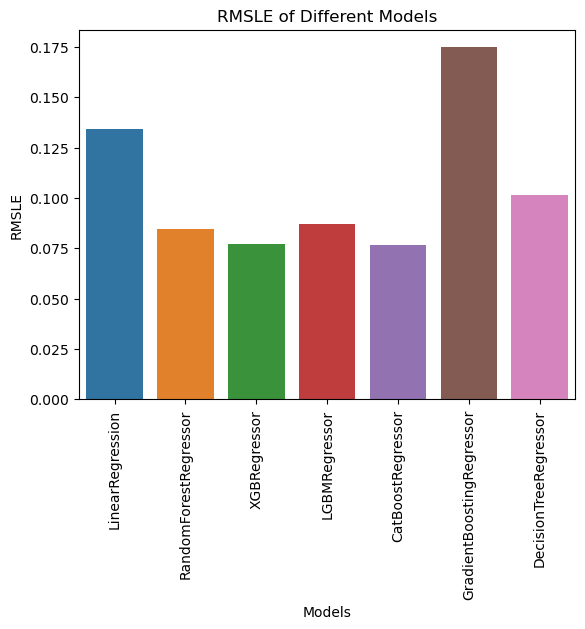

In [137]:
# Create a list of model names
model_names = ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'GradientBoostingRegressor', 'DecisionTreeRegressor']

# Create a list of RMSLE values
rmsle_values = [rmsle_lg, rmsle_RF, rmsle_xgb, rmsle_lgb, rmsle_cb, rmsle_gb, rmsle_dtm]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()


In [138]:
print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  CatBoostRegressor
RMSLE Value:  0.07653758759288866

Worst Model:  GradientBoostingRegressor
RMSLE Value:  0.17472331812952138


A low RMSLE value indicates that the model is making accurate predictions, so a very low RMSLE is generally considered desirable. However, a model with an RMSLE that is too low could indicate overfitting, where the model has become too specialized to the training data and is not generalizing well to new, unseen data. In these cases, it may be better to have a slightly higher RMSLE, as this would indicate that the model is making more general predictions that are less likely to be affected by small variations in the training data.

# FEATURE IMPORTANCE 

Feature importance is a technique for understanding the relative importance of features in a model. It involves assigning a score to each feature based on its contribution to the overall performance of the model. The scores can then be used to identify which features are the most important for making accurate predictions and which features may be redundant or even detrimental to the model's performance.

In the context of regression models, feature importance can be used to improve the RMLSE (root mean squared logarithmic error) by identifying which features have the most impact on the target variable and optimizing the model accordingly. By focusing on the most important features and eliminating or reducing the impact of less important ones, it is possible to improve the model's accuracy and reduce the RMLSE. Additionally, feature importance can be used to identify which features may be causing overfitting and adjust the model accordingly to improve its generalization performance.

##### Using the get_feature_importance method from the CatBoostRegressor

Here we use the get_feature_importance method from the CatBoostRegressor class to calculate the feature importances for the model trained on the input data. The feature importances are calculated using the "PredictionValuesChange" type, which indicates the contribution of each feature to the predictions made by the model. 

In [139]:
# Convert the pandas DataFrame to a catboost.Pool object
train_pool = Pool(data=X_train, label=y_train)

# Fit a CatBoostRegressor model to the data
model = CatBoostRegressor(random_state=0)
model.fit(train_pool)

# Calculate the feature importances
feature_importances = model.get_feature_importance(train_pool, type='PredictionValuesChange')

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)[::-1]


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 5.28ms	remaining: 5.28s
1:	learn: 124.4515551	total: 11.5ms	remaining: 5.75s
2:	learn: 121.1051420	total: 18.1ms	remaining: 6.02s
3:	learn: 118.0131759	total: 24.3ms	remaining: 6.06s
4:	learn: 115.1225090	total: 30.6ms	remaining: 6.08s
5:	learn: 112.5008885	total: 36.6ms	remaining: 6.07s
6:	learn: 109.7836982	total: 43.1ms	remaining: 6.12s
7:	learn: 107.4033951	total: 49.3ms	remaining: 6.11s
8:	learn: 104.9744962	total: 55.3ms	remaining: 6.08s
9:	learn: 102.8218347	total: 61.2ms	remaining: 6.06s
10:	learn: 100.6806423	total: 67.3ms	remaining: 6.05s
11:	learn: 98.4500980	total: 74.2ms	remaining: 6.11s
12:	learn: 96.6125667	total: 83.3ms	remaining: 6.32s
13:	learn: 94.6094222	total: 90.8ms	remaining: 6.39s
14:	learn: 92.6806954	total: 97.3ms	remaining: 6.39s
15:	learn: 90.6257312	total: 104ms	remaining: 6.37s
16:	learn: 88.9471067	total: 109ms	remaining: 6.32s
17:	learn: 87.3550268	total: 115ms	remaining: 6.28s
18:	learn: 85.8057

172:	learn: 43.5920824	total: 1.16s	remaining: 5.53s
173:	learn: 43.4970057	total: 1.16s	remaining: 5.52s
174:	learn: 43.4168152	total: 1.17s	remaining: 5.51s
175:	learn: 43.2997860	total: 1.18s	remaining: 5.5s
176:	learn: 43.1792339	total: 1.18s	remaining: 5.49s
177:	learn: 43.1252874	total: 1.19s	remaining: 5.48s
178:	learn: 42.9754305	total: 1.19s	remaining: 5.47s
179:	learn: 42.8965888	total: 1.2s	remaining: 5.47s
180:	learn: 42.7940289	total: 1.21s	remaining: 5.47s
181:	learn: 42.6848537	total: 1.21s	remaining: 5.45s
182:	learn: 42.6480654	total: 1.22s	remaining: 5.45s
183:	learn: 42.5390390	total: 1.23s	remaining: 5.43s
184:	learn: 42.4275283	total: 1.23s	remaining: 5.43s
185:	learn: 42.3883682	total: 1.24s	remaining: 5.42s
186:	learn: 42.2586781	total: 1.24s	remaining: 5.41s
187:	learn: 42.1700440	total: 1.25s	remaining: 5.4s
188:	learn: 42.0591891	total: 1.25s	remaining: 5.39s
189:	learn: 41.9643638	total: 1.26s	remaining: 5.37s
190:	learn: 41.8662348	total: 1.27s	remaining: 5.

351:	learn: 32.8423920	total: 2.4s	remaining: 4.42s
352:	learn: 32.8084340	total: 2.41s	remaining: 4.42s
353:	learn: 32.7995784	total: 2.42s	remaining: 4.41s
354:	learn: 32.7532110	total: 2.42s	remaining: 4.4s
355:	learn: 32.7431780	total: 2.43s	remaining: 4.4s
356:	learn: 32.7382603	total: 2.44s	remaining: 4.39s
357:	learn: 32.7154633	total: 2.44s	remaining: 4.38s
358:	learn: 32.6697600	total: 2.45s	remaining: 4.37s
359:	learn: 32.6306954	total: 2.46s	remaining: 4.37s
360:	learn: 32.5829184	total: 2.46s	remaining: 4.36s
361:	learn: 32.5562389	total: 2.47s	remaining: 4.35s
362:	learn: 32.5200941	total: 2.48s	remaining: 4.34s
363:	learn: 32.4887051	total: 2.48s	remaining: 4.34s
364:	learn: 32.4553891	total: 2.49s	remaining: 4.33s
365:	learn: 32.4248465	total: 2.49s	remaining: 4.32s
366:	learn: 32.3979115	total: 2.5s	remaining: 4.31s
367:	learn: 32.3844022	total: 2.51s	remaining: 4.3s
368:	learn: 32.3343934	total: 2.51s	remaining: 4.3s
369:	learn: 32.2872367	total: 2.52s	remaining: 4.29s

507:	learn: 28.1472781	total: 3.44s	remaining: 3.33s
508:	learn: 28.1184051	total: 3.44s	remaining: 3.32s
509:	learn: 28.0979078	total: 3.45s	remaining: 3.31s
510:	learn: 28.0825513	total: 3.46s	remaining: 3.31s
511:	learn: 28.0627211	total: 3.46s	remaining: 3.3s
512:	learn: 28.0437733	total: 3.47s	remaining: 3.29s
513:	learn: 28.0390602	total: 3.47s	remaining: 3.29s
514:	learn: 28.0335134	total: 3.48s	remaining: 3.28s
515:	learn: 28.0278160	total: 3.49s	remaining: 3.27s
516:	learn: 27.9968976	total: 3.49s	remaining: 3.26s
517:	learn: 27.9706964	total: 3.5s	remaining: 3.26s
518:	learn: 27.9518272	total: 3.51s	remaining: 3.25s
519:	learn: 27.9468026	total: 3.51s	remaining: 3.24s
520:	learn: 27.9181465	total: 3.52s	remaining: 3.24s
521:	learn: 27.8731281	total: 3.53s	remaining: 3.23s
522:	learn: 27.8564986	total: 3.53s	remaining: 3.22s
523:	learn: 27.8256025	total: 3.54s	remaining: 3.21s
524:	learn: 27.7987174	total: 3.55s	remaining: 3.21s
525:	learn: 27.7790199	total: 3.55s	remaining: 3

670:	learn: 24.7109632	total: 4.48s	remaining: 2.19s
671:	learn: 24.7041102	total: 4.48s	remaining: 2.19s
672:	learn: 24.6918342	total: 4.49s	remaining: 2.18s
673:	learn: 24.6615262	total: 4.5s	remaining: 2.17s
674:	learn: 24.6281769	total: 4.5s	remaining: 2.17s
675:	learn: 24.5908873	total: 4.51s	remaining: 2.16s
676:	learn: 24.5774948	total: 4.51s	remaining: 2.15s
677:	learn: 24.5588399	total: 4.52s	remaining: 2.15s
678:	learn: 24.5227096	total: 4.52s	remaining: 2.14s
679:	learn: 24.5075426	total: 4.53s	remaining: 2.13s
680:	learn: 24.4926485	total: 4.54s	remaining: 2.12s
681:	learn: 24.4809756	total: 4.54s	remaining: 2.12s
682:	learn: 24.4587005	total: 4.55s	remaining: 2.11s
683:	learn: 24.4532974	total: 4.55s	remaining: 2.1s
684:	learn: 24.4298495	total: 4.56s	remaining: 2.1s
685:	learn: 24.4176776	total: 4.56s	remaining: 2.09s
686:	learn: 24.3929247	total: 4.57s	remaining: 2.08s
687:	learn: 24.3774681	total: 4.57s	remaining: 2.07s
688:	learn: 24.3515830	total: 4.58s	remaining: 2.0

847:	learn: 21.8403648	total: 5.51s	remaining: 987ms
848:	learn: 21.8307205	total: 5.51s	remaining: 981ms
849:	learn: 21.8170336	total: 5.52s	remaining: 974ms
850:	learn: 21.8034172	total: 5.53s	remaining: 968ms
851:	learn: 21.7965771	total: 5.53s	remaining: 961ms
852:	learn: 21.7905218	total: 5.54s	remaining: 954ms
853:	learn: 21.7719746	total: 5.54s	remaining: 948ms
854:	learn: 21.7573706	total: 5.55s	remaining: 941ms
855:	learn: 21.7409476	total: 5.56s	remaining: 935ms
856:	learn: 21.7193378	total: 5.56s	remaining: 928ms
857:	learn: 21.7056212	total: 5.57s	remaining: 921ms
858:	learn: 21.6905191	total: 5.57s	remaining: 915ms
859:	learn: 21.6800418	total: 5.58s	remaining: 908ms
860:	learn: 21.6684304	total: 5.59s	remaining: 902ms
861:	learn: 21.6505715	total: 5.59s	remaining: 895ms
862:	learn: 21.6345205	total: 5.6s	remaining: 889ms
863:	learn: 21.6281894	total: 5.6s	remaining: 882ms
864:	learn: 21.6130853	total: 5.61s	remaining: 876ms
865:	learn: 21.6039311	total: 5.62s	remaining: 8

In [140]:
# Print the feature importances
for idx in sorted_idx:
    print("{}: {:.3f}".format(X_train.columns[idx], feature_importances[idx]))


onpromotion_encoded: 41.387
weekday: 24.423
dcoilwtico: 7.274
transactions: 6.934
quarter: 3.409
month: 3.118
pct_change: 3.035
week_lag_1: 1.834
next_day_sales: 1.487
week_ma_7: 1.246
week: 1.245
week_ma_14: 1.189
Promotions_bin_0: 1.083
week_ma_30: 0.886
Promotions_bin_1: 0.833
Holiday_type_Holiday: 0.118
Min: 0.046
city_Guayaquil: 0.040
city_Salinas: 0.035
family_Beverages: 0.035
Store_type_A: 0.027
city_Manta: 0.026
city_Santo_Domingo: 0.025
city_Riobamba: 0.025
city_Babahoyo: 0.024
Store_type_C: 0.021
Promotions_bin_2: 0.020
city_Playas: 0.015
Store_type_D: 0.015
Promotions_bin_3: 0.014
city_El_Carmen: 0.014
city_Ambato: 0.013
city_Cayambe: 0.013
Store_type_E: 0.013
city_Puyo: 0.011
cluster: 0.011
city_Machala: 0.010
city_Latacunga: 0.009
Holiday_type_Workday: 0.008
diff_1: 0.007
city_Quevedo: 0.007
family_Others: 0.005
Store_type_B: 0.005
city_Daule: 0.004
family_Food: 0.002
family_Clothing: 0.002
city_Loja: 0.001
store_nbr: 0.000
city_Libertad: 0.000
city_Ibarra: 0.000
city_Guar

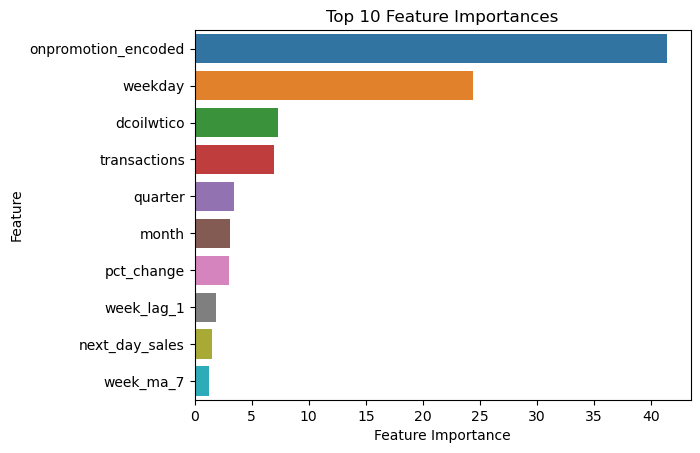

In [141]:
# Plot the feature importances
sns.barplot(x=feature_importances[sorted_idx[:10]], y=X_train.columns[sorted_idx[:10]])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')

plt.show()

For catboost regressor, the following attributes above contribute the most of improving the prediction and reducing the RMSLE. 

#### Select the top features and train the model

In [142]:
#The next step to improve the performace of CatboostRegressor is to select the top features and train the model on only those features. 

#Here we set a threshold score of 1 and above to be the criteria for selecting the feature. 

#Since we have already implemented the feture importance, we can use this to select the bet features. 


# Fit a CatBoostRegressor model to the data
model = CatBoostRegressor(random_state=0)
model.fit(X_train, y_train)

# Convert the pandas DataFrame to a catboost.Pool object
train_pool = Pool(data=X_train, label=y_train)

# Calculate the feature importances
feature_importances = model.get_feature_importance(train_pool, type='PredictionValuesChange')

# Set a threshold for the minimum importance to keep a feature
importance_threshold = 1

# Keep only the features with importance above the threshold
X_important = X_train.iloc[:, feature_importances > importance_threshold]

# Fit the CatBoostRegressor model to the important features only
model_important = CatBoostRegressor()
model_important.fit(X_important, y_train)

# Make predictions on the reduced feature set
y_pred = model_important.predict(X_important)


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 5.19ms	remaining: 5.18s
1:	learn: 124.4515551	total: 10.9ms	remaining: 5.43s
2:	learn: 121.1051420	total: 16.1ms	remaining: 5.34s
3:	learn: 118.0131759	total: 22.1ms	remaining: 5.51s
4:	learn: 115.1225090	total: 27.6ms	remaining: 5.5s
5:	learn: 112.5008885	total: 33.2ms	remaining: 5.5s
6:	learn: 109.7836982	total: 39ms	remaining: 5.54s
7:	learn: 107.4033951	total: 44.2ms	remaining: 5.48s
8:	learn: 104.9744962	total: 49ms	remaining: 5.4s
9:	learn: 102.8218347	total: 55ms	remaining: 5.45s
10:	learn: 100.6806423	total: 60.4ms	remaining: 5.43s
11:	learn: 98.4500980	total: 66ms	remaining: 5.43s
12:	learn: 96.6125667	total: 71.4ms	remaining: 5.42s
13:	learn: 94.6094222	total: 76.5ms	remaining: 5.38s
14:	learn: 92.6806954	total: 82.1ms	remaining: 5.39s
15:	learn: 90.6257312	total: 87.7ms	remaining: 5.39s
16:	learn: 88.9471067	total: 92.8ms	remaining: 5.37s
17:	learn: 87.3550268	total: 98.1ms	remaining: 5.35s
18:	learn: 85.8057306	tota

163:	learn: 44.4489932	total: 989ms	remaining: 5.04s
164:	learn: 44.3855017	total: 995ms	remaining: 5.04s
165:	learn: 44.2838249	total: 1s	remaining: 5.04s
166:	learn: 44.1942741	total: 1.01s	remaining: 5.03s
167:	learn: 44.1093804	total: 1.01s	remaining: 5.02s
168:	learn: 43.9791523	total: 1.02s	remaining: 5.03s
169:	learn: 43.8647297	total: 1.03s	remaining: 5.02s
170:	learn: 43.8189249	total: 1.03s	remaining: 5.01s
171:	learn: 43.6776341	total: 1.04s	remaining: 5.01s
172:	learn: 43.5920824	total: 1.04s	remaining: 5s
173:	learn: 43.4970057	total: 1.05s	remaining: 5s
174:	learn: 43.4168152	total: 1.06s	remaining: 4.99s
175:	learn: 43.2997860	total: 1.06s	remaining: 4.98s
176:	learn: 43.1792339	total: 1.07s	remaining: 4.97s
177:	learn: 43.1252874	total: 1.08s	remaining: 4.97s
178:	learn: 42.9754305	total: 1.08s	remaining: 4.97s
179:	learn: 42.8965888	total: 1.09s	remaining: 4.96s
180:	learn: 42.7940289	total: 1.09s	remaining: 4.95s
181:	learn: 42.6848537	total: 1.1s	remaining: 4.95s
182

319:	learn: 33.9849850	total: 1.96s	remaining: 4.17s
320:	learn: 33.9779947	total: 1.97s	remaining: 4.16s
321:	learn: 33.9607479	total: 1.97s	remaining: 4.16s
322:	learn: 33.9190210	total: 1.98s	remaining: 4.15s
323:	learn: 33.8830648	total: 1.99s	remaining: 4.14s
324:	learn: 33.8357919	total: 1.99s	remaining: 4.14s
325:	learn: 33.7747838	total: 2s	remaining: 4.13s
326:	learn: 33.7126245	total: 2s	remaining: 4.13s
327:	learn: 33.6741139	total: 2.01s	remaining: 4.12s
328:	learn: 33.6496021	total: 2.02s	remaining: 4.11s
329:	learn: 33.6134507	total: 2.02s	remaining: 4.11s
330:	learn: 33.5837237	total: 2.03s	remaining: 4.1s
331:	learn: 33.5644489	total: 2.04s	remaining: 4.1s
332:	learn: 33.5252406	total: 2.04s	remaining: 4.09s
333:	learn: 33.4593101	total: 2.05s	remaining: 4.09s
334:	learn: 33.4216406	total: 2.06s	remaining: 4.08s
335:	learn: 33.3869869	total: 2.06s	remaining: 4.08s
336:	learn: 33.3623146	total: 2.07s	remaining: 4.07s
337:	learn: 33.3086334	total: 2.08s	remaining: 4.07s
3

496:	learn: 28.4153026	total: 3.2s	remaining: 3.24s
497:	learn: 28.3881765	total: 3.21s	remaining: 3.23s
498:	learn: 28.3533906	total: 3.21s	remaining: 3.23s
499:	learn: 28.3236564	total: 3.22s	remaining: 3.22s
500:	learn: 28.2933030	total: 3.23s	remaining: 3.22s
501:	learn: 28.2694781	total: 3.24s	remaining: 3.21s
502:	learn: 28.2480731	total: 3.24s	remaining: 3.2s
503:	learn: 28.2253591	total: 3.25s	remaining: 3.2s
504:	learn: 28.2059789	total: 3.26s	remaining: 3.19s
505:	learn: 28.2015559	total: 3.26s	remaining: 3.19s
506:	learn: 28.1792882	total: 3.27s	remaining: 3.18s
507:	learn: 28.1472781	total: 3.28s	remaining: 3.17s
508:	learn: 28.1184051	total: 3.28s	remaining: 3.17s
509:	learn: 28.0979078	total: 3.29s	remaining: 3.16s
510:	learn: 28.0825513	total: 3.3s	remaining: 3.15s
511:	learn: 28.0627211	total: 3.3s	remaining: 3.15s
512:	learn: 28.0437733	total: 3.31s	remaining: 3.14s
513:	learn: 28.0390602	total: 3.32s	remaining: 3.13s
514:	learn: 28.0335134	total: 3.32s	remaining: 3.13

673:	learn: 24.6615262	total: 4.4s	remaining: 2.13s
674:	learn: 24.6281769	total: 4.41s	remaining: 2.12s
675:	learn: 24.5908873	total: 4.42s	remaining: 2.12s
676:	learn: 24.5774948	total: 4.42s	remaining: 2.11s
677:	learn: 24.5588399	total: 4.43s	remaining: 2.1s
678:	learn: 24.5227096	total: 4.43s	remaining: 2.1s
679:	learn: 24.5075426	total: 4.44s	remaining: 2.09s
680:	learn: 24.4926485	total: 4.45s	remaining: 2.08s
681:	learn: 24.4809756	total: 4.46s	remaining: 2.08s
682:	learn: 24.4587005	total: 4.46s	remaining: 2.07s
683:	learn: 24.4532974	total: 4.47s	remaining: 2.06s
684:	learn: 24.4298495	total: 4.47s	remaining: 2.06s
685:	learn: 24.4176776	total: 4.48s	remaining: 2.05s
686:	learn: 24.3929247	total: 4.49s	remaining: 2.04s
687:	learn: 24.3774681	total: 4.49s	remaining: 2.04s
688:	learn: 24.3515830	total: 4.5s	remaining: 2.03s
689:	learn: 24.3375572	total: 4.51s	remaining: 2.02s
690:	learn: 24.3159926	total: 4.51s	remaining: 2.02s
691:	learn: 24.3019148	total: 4.52s	remaining: 2.0

851:	learn: 21.7965771	total: 5.62s	remaining: 977ms
852:	learn: 21.7905218	total: 5.63s	remaining: 970ms
853:	learn: 21.7719746	total: 5.64s	remaining: 964ms
854:	learn: 21.7573706	total: 5.64s	remaining: 957ms
855:	learn: 21.7409476	total: 5.65s	remaining: 950ms
856:	learn: 21.7193378	total: 5.66s	remaining: 944ms
857:	learn: 21.7056212	total: 5.66s	remaining: 938ms
858:	learn: 21.6905191	total: 5.67s	remaining: 931ms
859:	learn: 21.6800418	total: 5.68s	remaining: 924ms
860:	learn: 21.6684304	total: 5.68s	remaining: 918ms
861:	learn: 21.6505715	total: 5.69s	remaining: 911ms
862:	learn: 21.6345205	total: 5.7s	remaining: 904ms
863:	learn: 21.6281894	total: 5.7s	remaining: 898ms
864:	learn: 21.6130853	total: 5.71s	remaining: 891ms
865:	learn: 21.6039311	total: 5.71s	remaining: 884ms
866:	learn: 21.5981772	total: 5.72s	remaining: 878ms
867:	learn: 21.5681147	total: 5.73s	remaining: 871ms
868:	learn: 21.5519472	total: 5.73s	remaining: 864ms
869:	learn: 21.5439459	total: 5.74s	remaining: 8

11:	learn: 98.3514194	total: 41.9ms	remaining: 3.45s
12:	learn: 96.2662645	total: 45.8ms	remaining: 3.48s
13:	learn: 94.1424573	total: 49.2ms	remaining: 3.46s
14:	learn: 92.4789257	total: 52.6ms	remaining: 3.45s
15:	learn: 90.7346062	total: 56.3ms	remaining: 3.46s
16:	learn: 88.9080171	total: 60ms	remaining: 3.47s
17:	learn: 87.2249212	total: 63.6ms	remaining: 3.47s
18:	learn: 85.6308345	total: 67.6ms	remaining: 3.49s
19:	learn: 84.1560371	total: 71.8ms	remaining: 3.52s
20:	learn: 82.7754540	total: 75.7ms	remaining: 3.53s
21:	learn: 81.4256057	total: 79.9ms	remaining: 3.55s
22:	learn: 80.0480691	total: 83.7ms	remaining: 3.55s
23:	learn: 78.8586321	total: 87.6ms	remaining: 3.56s
24:	learn: 77.7268125	total: 91.5ms	remaining: 3.57s
25:	learn: 76.6033988	total: 95.3ms	remaining: 3.57s
26:	learn: 75.6248362	total: 99.1ms	remaining: 3.57s
27:	learn: 74.6519394	total: 103ms	remaining: 3.57s
28:	learn: 73.5568663	total: 106ms	remaining: 3.56s
29:	learn: 72.6771917	total: 110ms	remaining: 3.55

168:	learn: 42.6899799	total: 622ms	remaining: 3.06s
169:	learn: 42.6028442	total: 626ms	remaining: 3.06s
170:	learn: 42.4923741	total: 630ms	remaining: 3.06s
171:	learn: 42.4169633	total: 634ms	remaining: 3.05s
172:	learn: 42.2907623	total: 639ms	remaining: 3.05s
173:	learn: 42.2401163	total: 643ms	remaining: 3.05s
174:	learn: 42.0986959	total: 647ms	remaining: 3.05s
175:	learn: 41.9936413	total: 652ms	remaining: 3.05s
176:	learn: 41.9335025	total: 656ms	remaining: 3.05s
177:	learn: 41.8264001	total: 660ms	remaining: 3.04s
178:	learn: 41.7511986	total: 663ms	remaining: 3.04s
179:	learn: 41.6715316	total: 667ms	remaining: 3.04s
180:	learn: 41.6297694	total: 671ms	remaining: 3.04s
181:	learn: 41.5206036	total: 674ms	remaining: 3.03s
182:	learn: 41.4471026	total: 678ms	remaining: 3.03s
183:	learn: 41.3454078	total: 682ms	remaining: 3.02s
184:	learn: 41.2827284	total: 686ms	remaining: 3.02s
185:	learn: 41.1984397	total: 689ms	remaining: 3.02s
186:	learn: 41.0878487	total: 692ms	remaining:

364:	learn: 31.7641220	total: 1.41s	remaining: 2.45s
365:	learn: 31.7552776	total: 1.41s	remaining: 2.45s
366:	learn: 31.7242796	total: 1.42s	remaining: 2.45s
367:	learn: 31.6658315	total: 1.42s	remaining: 2.44s
368:	learn: 31.6249839	total: 1.43s	remaining: 2.44s
369:	learn: 31.6100132	total: 1.43s	remaining: 2.43s
370:	learn: 31.5475192	total: 1.43s	remaining: 2.43s
371:	learn: 31.5111288	total: 1.44s	remaining: 2.43s
372:	learn: 31.4873999	total: 1.44s	remaining: 2.42s
373:	learn: 31.4577718	total: 1.44s	remaining: 2.42s
374:	learn: 31.4306737	total: 1.45s	remaining: 2.41s
375:	learn: 31.3886016	total: 1.45s	remaining: 2.41s
376:	learn: 31.3575230	total: 1.46s	remaining: 2.4s
377:	learn: 31.3324713	total: 1.46s	remaining: 2.4s
378:	learn: 31.3056382	total: 1.46s	remaining: 2.4s
379:	learn: 31.2611029	total: 1.47s	remaining: 2.39s
380:	learn: 31.2205145	total: 1.47s	remaining: 2.39s
381:	learn: 31.2085981	total: 1.48s	remaining: 2.39s
382:	learn: 31.1675581	total: 1.48s	remaining: 2.

566:	learn: 26.2903075	total: 2.21s	remaining: 1.69s
567:	learn: 26.2672648	total: 2.21s	remaining: 1.68s
568:	learn: 26.2408225	total: 2.21s	remaining: 1.68s
569:	learn: 26.2338957	total: 2.22s	remaining: 1.67s
570:	learn: 26.1959775	total: 2.22s	remaining: 1.67s
571:	learn: 26.1825277	total: 2.23s	remaining: 1.67s
572:	learn: 26.1523500	total: 2.23s	remaining: 1.66s
573:	learn: 26.1162246	total: 2.23s	remaining: 1.66s
574:	learn: 26.0873435	total: 2.24s	remaining: 1.65s
575:	learn: 26.0755795	total: 2.24s	remaining: 1.65s
576:	learn: 26.0519356	total: 2.24s	remaining: 1.65s
577:	learn: 26.0413046	total: 2.25s	remaining: 1.64s
578:	learn: 26.0243031	total: 2.25s	remaining: 1.64s
579:	learn: 26.0111738	total: 2.25s	remaining: 1.63s
580:	learn: 26.0036797	total: 2.26s	remaining: 1.63s
581:	learn: 25.9817346	total: 2.26s	remaining: 1.63s
582:	learn: 25.9636714	total: 2.27s	remaining: 1.62s
583:	learn: 25.9460941	total: 2.27s	remaining: 1.62s
584:	learn: 25.9151049	total: 2.27s	remaining:

722:	learn: 23.6259423	total: 2.78s	remaining: 1.06s
723:	learn: 23.6079779	total: 2.78s	remaining: 1.06s
724:	learn: 23.5937840	total: 2.79s	remaining: 1.06s
725:	learn: 23.5859326	total: 2.79s	remaining: 1.05s
726:	learn: 23.5758695	total: 2.79s	remaining: 1.05s
727:	learn: 23.5308702	total: 2.8s	remaining: 1.05s
728:	learn: 23.5093231	total: 2.8s	remaining: 1.04s
729:	learn: 23.4948524	total: 2.81s	remaining: 1.04s
730:	learn: 23.4904371	total: 2.81s	remaining: 1.03s
731:	learn: 23.4872348	total: 2.81s	remaining: 1.03s
732:	learn: 23.4545128	total: 2.82s	remaining: 1.03s
733:	learn: 23.4425335	total: 2.82s	remaining: 1.02s
734:	learn: 23.4189217	total: 2.83s	remaining: 1.02s
735:	learn: 23.3966169	total: 2.83s	remaining: 1.01s
736:	learn: 23.3839436	total: 2.83s	remaining: 1.01s
737:	learn: 23.3675740	total: 2.84s	remaining: 1.01s
738:	learn: 23.3366125	total: 2.84s	remaining: 1s
739:	learn: 23.3153502	total: 2.85s	remaining: 1000ms
740:	learn: 23.3012923	total: 2.85s	remaining: 996

879:	learn: 21.3875616	total: 3.35s	remaining: 458ms
880:	learn: 21.3815436	total: 3.36s	remaining: 454ms
881:	learn: 21.3686200	total: 3.36s	remaining: 450ms
882:	learn: 21.3482177	total: 3.37s	remaining: 446ms
883:	learn: 21.3385774	total: 3.37s	remaining: 442ms
884:	learn: 21.3191303	total: 3.37s	remaining: 438ms
885:	learn: 21.3062275	total: 3.38s	remaining: 435ms
886:	learn: 21.2915938	total: 3.38s	remaining: 431ms
887:	learn: 21.2851013	total: 3.39s	remaining: 427ms
888:	learn: 21.2752202	total: 3.39s	remaining: 423ms
889:	learn: 21.2677387	total: 3.39s	remaining: 419ms
890:	learn: 21.2646990	total: 3.4s	remaining: 416ms
891:	learn: 21.2516005	total: 3.4s	remaining: 412ms
892:	learn: 21.2346755	total: 3.4s	remaining: 408ms
893:	learn: 21.2249850	total: 3.41s	remaining: 404ms
894:	learn: 21.2068933	total: 3.41s	remaining: 400ms
895:	learn: 21.1860234	total: 3.41s	remaining: 396ms
896:	learn: 21.1734043	total: 3.42s	remaining: 393ms
897:	learn: 21.1461075	total: 3.42s	remaining: 38

In [143]:
# Make predictions on the validation set
y_val_pred = model_important.predict(X_validation_test)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_validation_test, y_val_pred)
print("MSE: {:.3f}".format(mse))

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("RMSE: {:.3f}".format(rmse))


# Calculate the root mean squared logarithmic error (RMSLE)
rmsle_cb_3 = np.sqrt(np.mean((np.log(y_val_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: {:.3f}".format(rmsle_cb_3))

MSE: 1326.683
RMSE: 36.424
RMSLE: 0.074


#### Permutation importance 

Permutation importance is a method to calculate the importance of individual features in a machine learning model. The idea behind permutation importance is to randomly shuffle the values of a single feature and observe the resulting decrease in the model performance. The decrease in the performance metric indicates the importance of the feature. The more the decrease in the performance, the more important the feature is considered to be.

Permutation importance can be used to improve RandomForestRegressor in the following ways:

Feature selection: By calculating permutation importance, you can identify the most important features for your prediction task. You can then use this information to select the most important features for training your RandomForestRegressor model, which can result in improved performance and reduced training time.

Model improvement: By using permutation importance, you can also identify features that are not contributing much to the model's performance. By removing such features from the training data, you can improve the performance of the RandomForestRegressor model.

In [144]:
from sklearn.inspection import permutation_importance

# Fit the Random Forest Regressor on the training data
reg = RandomForestRegressor(random_state=0)
reg.fit(X_train, y_train)

# Calculate the permutation importance for each feature
result = permutation_importance(reg, X_validation_test, y_validation_test, n_repeats=10, random_state=0)

# Create a DataFrame to store the feature names and their corresponding permutation importance score
feature_importance = pd.DataFrame({'feature': X_validation_test.columns,
                                   'permutation_importance': result.importances.mean(axis=1)})

# Sort the DataFrame by permutation importance in descending order
feature_importance.sort_values(by='permutation_importance', ascending=False, inplace=True)

# Print the top 10 most important features
print(feature_importance.head(10))


                feature  permutation_importance
7               weekday                1.402408
2          transactions                0.417739
14           pct_change                0.126027
17  onpromotion_encoded                0.009429
26     Promotions_bin_0                0.008143
27     Promotions_bin_1                0.005794
3            dcoilwtico                0.002552
12           week_ma_30                0.002140
11           week_ma_14                0.001359
9        next_day_sales                0.001256


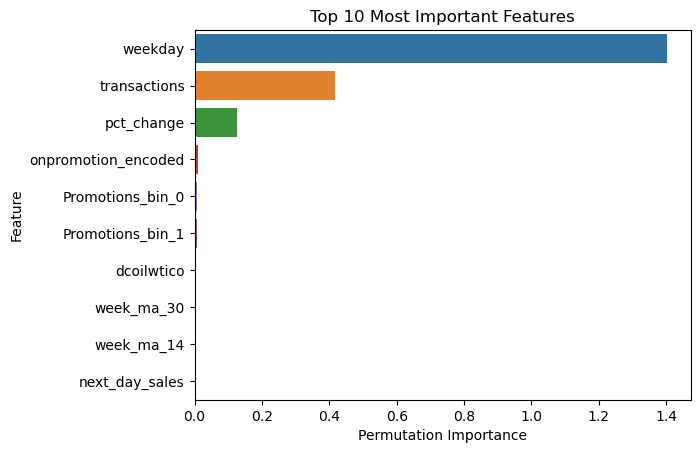

In [145]:
sns.barplot(x='permutation_importance', y='feature', data=feature_importance.head(10))
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()

#### Select the top n features to re-train the RandomForestRegressor 

In [146]:
# Select the top n features to re-train the RandomForestRegressor in hopes of improving the model

n = 10 # number of top features
X_important = X_train[feature_importance['feature'].head(n)]

# Train the RandomForestRegressor on the selected features
reg_important = RandomForestRegressor(random_state=0)
reg_important.fit(X_important, y_train)

best_model_RFR = reg_important

# Make predictions on the validation set using the new model
y_pred = reg_important.predict(X_validation_test[feature_importance['feature'].head(n)])




In [147]:
# Calculate the RMSLE
rmsle_RF_opt = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: {:.3f}".format(rmsle_RF_opt))

RMSLE: 0.073


### Using shapely Values for the feature importance 

In [148]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


Shapely values are a feature importance measure used in machine learning to evaluate the contribution of each feature towards the model's prediction. They measure the change in the model's prediction when the feature is excluded or permuted randomly. Higher the shapely value, higher is the contribution of the feature towards the model's prediction.

To use shapely values to evaluate the feature importance, you can calculate the prediction values change when a feature is excluded or permuted, and compare it to the prediction values of the original model. You can calculate the shapely values for each feature and rank them in order to determine the most important features in your model.

By using shapely values to evaluate the feature importance, you can get a better understanding of how the features are contributing to the model's prediction, and you can use this information to improve the performance of your RandomForestRegressor. For example, you can remove the features that have a low shapely value or use feature engineering to create new features that have a higher shapely value.

In [149]:
import shap

# Need to load JS vis in the notebook
shap.initjs()

In [150]:
from xgboost import XGBRegressor

# instantiate the regressor
xgc = XGBRegressor(random_state=0)

# fit the XGBoost regressor
xgc.fit(X_train, y_train)

# create the explainer
explainer = shap.Explainer(xgc.predict, X_train)

# calculate the SHAP values for the validation test data
shap_values = explainer(X_validation_test)

# get the expected value
expected_value = xgc.predict(X_train).mean()
print('Expected Value:', expected_value)


Permutation explainer: 86it [00:32,  2.14it/s]                        

Expected Value: 350.44537


The implication of the expected value depends on the specific problem you are trying to solve and the context of your analysis. In general, a high expected value is desirable, as it suggests that the features you have selected for your model are important for making accurate predictions. On the other hand, a low expected value may indicate that you need to reconsider your feature selection strategy, or that you may need to collect additional data to improve the performance of your model.

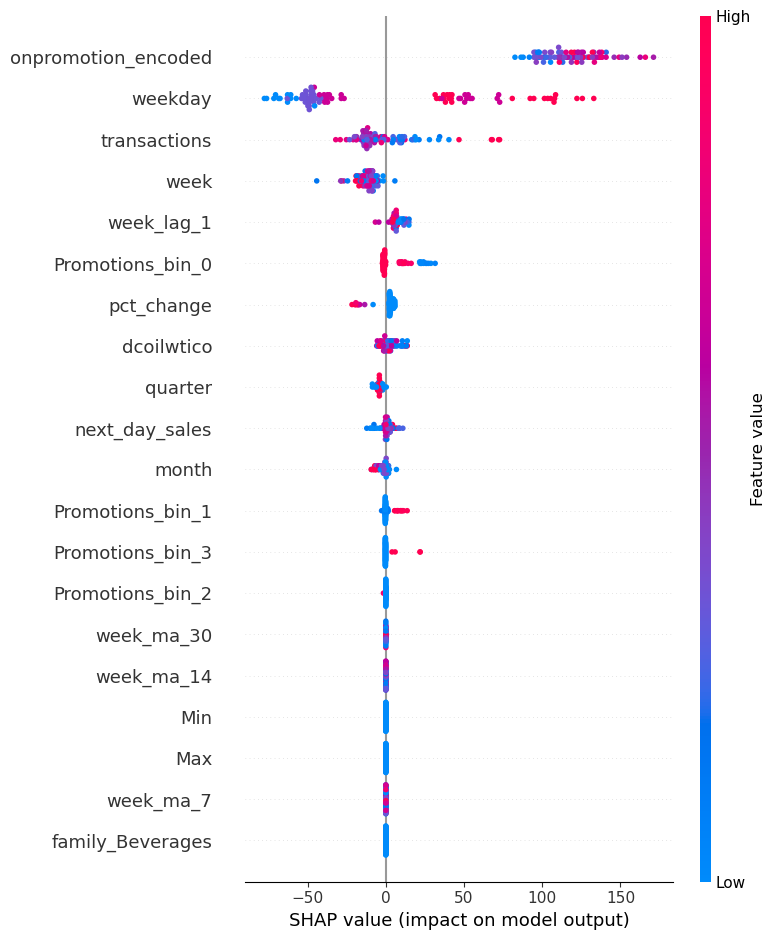

In [151]:
#Global Interpretaion

shap.summary_plot(shap_values, X_validation_test)

##### Select the top n features and retrain the XGBRegressor

In [152]:
# Select the top n features
n = 10 # number of top features
X_important = X_train.iloc[:, np.argsort(np.abs(shap_values.values).mean(0))[-n:]]

xgc_important = XGBRegressor(random_state=0)
xgc_important.fit(X_important, y_train)

y_val_pred = xgc_important.predict(X_validation_test.loc[:, X_important.columns])

# Calculate the root mean squared logarithmic error (RMSLE)
rmsle_XGB_O = np.sqrt(np.mean((np.log(y_val_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: {:.3f}".format(rmsle_XGB_O))


RMSLE: 0.076


#### Using the get_score method from the XGBRegressor

The get_score method from the XGBRegressor returns a dictionary of feature importance scores based on the number of times each feature is split on across all trees in the model. These scores can be used to identify the most important features in the dataset and can provide insights into which features are most strongly associated with the target variable.

In [153]:
# Use XGBRegressor to obtain the feature importance scores

xgb = XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)

# Get the feature importance scores
importance = xgb.get_booster().get_score(importance_type='weight')

# Convert the feature importance scores to a DataFrame and sort by score in descending order
importance_df = pd.DataFrame(list(importance.items()), columns=['feature', 'score'])
importance_df.sort_values(by='score', ascending=False, inplace=True)

# Select the top n features
n = 10 # specify the number of top features
top_features = importance_df['feature'].head(n)

# Train XGBRegressor on the top n features
xgb_top_features = XGBRegressor(random_state=0)
xgb_top_features.fit(X_train[top_features], y_train)

# Predict using the model trained on top n features
y_pred = xgb_top_features.predict(X_validation_test[top_features])

# Calculate the RMSLE
rmsle_XGB_O2 = np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: ", rmsle_XGB_O2)


RMSLE:  0.07251688197346871


###### Comparison for all models 

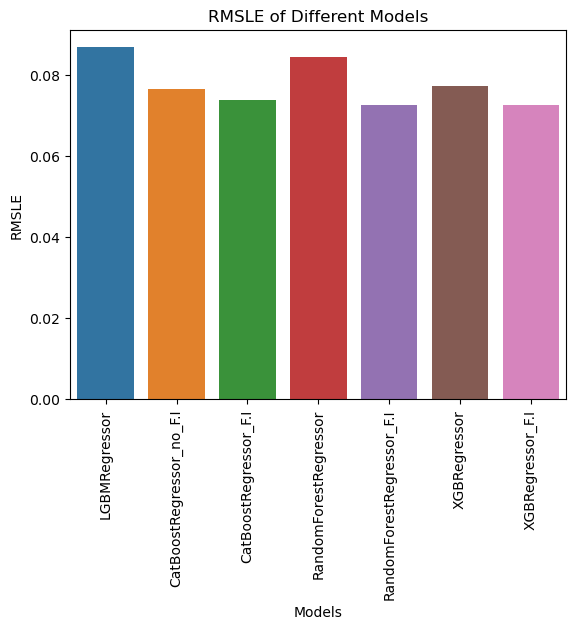

In [154]:
# Create a list of model names
model_names = ['LGBMRegressor', 'CatBoostRegressor_no_F.I', 'CatBoostRegressor_F.I','RandomForestRegressor','RandomForestRegressor_F.I','XGBRegressor','XGBRegressor_F.I' ]

# Create a list of RMSLE values
rmsle_values = [rmsle_lgb, rmsle_cb, rmsle_cb_3, rmsle_RF, rmsle_RF_opt,rmsle_xgb,rmsle_XGB_O2]

# Create a list of model names
#model_names = ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'GradientBoostingRegressor', 'DecisionTreeRegressor']

# Create a list of RMSLE values
#rmsle_values = [rmsle_lg, rmsle_RF, rmsle_xgb, rmsle_lgb, rmsle_cb, rmsle_gb, rmsle_dtm]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()

In [155]:

print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  XGBRegressor_F.I
RMSLE Value:  0.07251688197346871

Worst Model:  LGBMRegressor
RMSLE Value:  0.08682008636140302


# HYPERPARAMETER TUNING 

Hyperparameter tuning can improve the RMSLE (Root Mean Squared Logarithmic Error) of a regression model by selecting the hyperparameters that result in the best performance on the validation set. By finding the optimal set of hyperparameters, the model can generalize better to new, unseen data, which is reflected in a lower RMSLE. Additionally, hyperparameter tuning can help prevent overfitting, which is a common problem in machine learning.

Since GradientBoostingRegressor and linear regressor did not perform too well, we deiced to use hyperparameter tuning to improve the model. 

##### GradientBoostingRegressor with hyperparameter tuning 

In [156]:
#First step in for GradientBoostingRegressor

# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

# Initialize the GradientBoostingRegressor
reg = GradientBoostingRegressor()

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(reg, param_grid, n_iter=10, scoring='neg_mean_squared_log_error', cv=5)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Get the best estimator from the random search
best_reg = random_search.best_estimator_

# Predict on the test data using the best estimator
y_pred = best_reg.predict(X_validation_test)


Best parameters found:  {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.1}


In [157]:
# Calculate the RMSLE
rmsle_gbr_h = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: ", rmsle_gbr_h)

RMSLE:  0.08462851511122316


##### Compare GradientBoostingRegressor with hyperparameter tuning and without

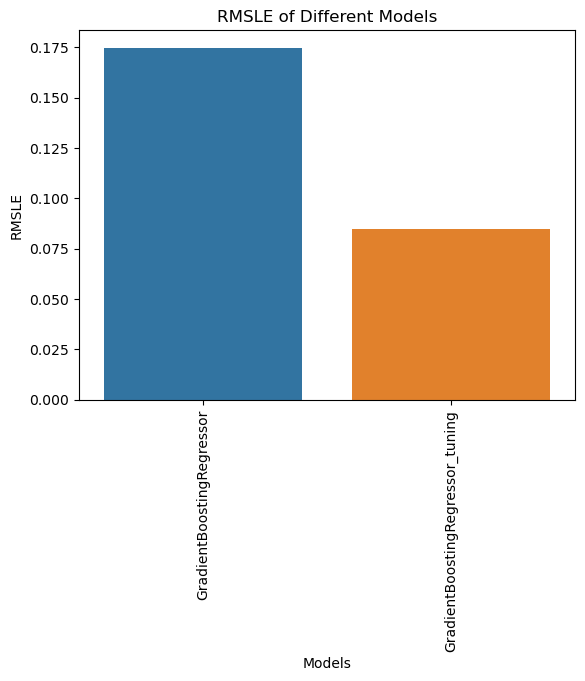

In [158]:
# Create a list of model names
model_names = ['GradientBoostingRegressor', 'GradientBoostingRegressor_tuning' ]

# Create a list of RMSLE values
rmsle_values = [rmsle_gb, rmsle_gbr_h]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()

In [159]:
# Create a list of RMSLE values
percent_change = (rmsle_gb - rmsle_gbr_h)/rmsle_gb *100

percent_change

51.56426971671375

This shows that using hyperprameter tuning significantly improved the RMSLE by 20% 

##### LinearRegression with hyperparameter tuning 

In [160]:
# Second step is LinearRegression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to be tuned
param_grid = {'normalize': [True, False]}

# Initialize the linear regression model
reg = LinearRegression()

# Initialize the grid search object
grid_search = GridSearchCV(reg, param_grid, cv=100, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Predict on the validation test data
y_pred = grid_search.predict(X_validation_test)

# Calculate the RMSLE
rmsle_lg_hyp = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: ", rmsle_lg_hyp)


Best hyperparameters:  {'normalize': False}
RMSLE:  0.13441791421327232


#### Linear Regression with Top 10 Features using Grid Search and Cross Validation

In [161]:
# Select the top 20 features based on permutation importance
top_10_features = feature_importance.head(10)['feature']
X_train_10 = X_train[top_10_features]
X_validation_test_10 = X_validation_test[top_10_features]

# Train a Linear Regression model on the top 20 features
lin_reg = LinearRegression()

# Define the parameter grid for GridSearchCV
param_grid = {'normalize': [True, False]}

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(lin_reg, param_grid, cv=100, scoring='neg_mean_squared_error')
grid_search.fit(X_train_10, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Make predictions on the validation set
y_pred = grid_search.predict(X_validation_test_10)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_validation_test, y_pred)
print("Mean Squared Error on the validation set: ", mse)

# Calculate the RMSLE
rmsle_lg_top = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: ", rmsle_lg_top)


Best parameters:  {'normalize': True}
Best score:  -6676.820223191986
Mean Squared Error on the validation set:  4679.198718758269
RMSLE:  0.13480499948336974


##### Compare LinearRegressor with hyperparameter tuning and without

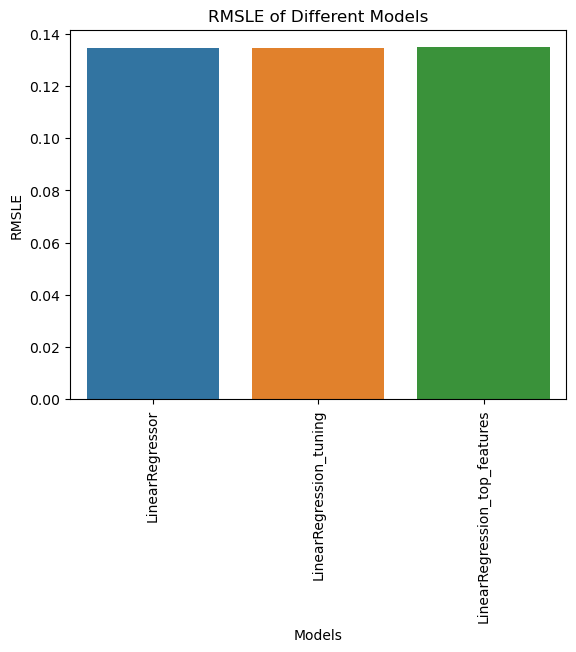

In [162]:
# Create a list of model names
model_names = ['LinearRegressor', 'LinearRegression_tuning', "LinearRegression_top_features" ]

# Create a list of RMSLE values
rmsle_values = [rmsle_lg, rmsle_lg_hyp, rmsle_lg_top]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()

In [163]:
print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  LinearRegressor
RMSLE Value:  0.13441791421327232

Worst Model:  LinearRegression_top_features
RMSLE Value:  0.13480499948336974


As can be oberserved there was no significant improvement in the RMSLE metric even with hyperparameter tuning and feature importance. 

In [164]:
import joblib

Save the model to disk

In [165]:
# Save the selected-feature XGBRegressor model to a file using joblib
filename = 'xgb_model_selected_features.joblib'
joblib.dump(xgb_top_features, filename)

['xgb_model_selected_features.joblib']

In [166]:
# Check if the model is an XGBRegressor or not
if isinstance(xgb_top_features, XGBRegressor):
    # Save the XGBRegressor model to a file using joblib
    filename = 'xgb_model_selected_features.joblib'
    joblib.dump(xgb_top_features, filename)
    print("XGBRegressor model saved successfully.")
else:
    print("Error: Invalid model type.")


XGBRegressor model saved successfully.


Making Predictions on Test Data using a Saved Random Forest Model

In [167]:
# Load the saved XGBoost model from file
loaded_model = joblib.load('xgb_model_selected_features.joblib')

# Load the test data from file
test_data = Final_test_data_

# Select the same top 10 features as used to train the model

n = 10 # number of top features

X_test_important = test_data[importance_df['feature'].head(n)]

# Make predictions on the test data using the loaded model
predictions = loaded_model.predict(X_test_important)

# Display the predictions
print(predictions)


[495.85532 407.7701  362.05673 399.7322  408.6408  378.14206 416.00812
 415.02298 400.8801  393.36514 419.82135 408.2016  351.24142 381.90677
 408.31973 410.4984 ]
